<a href="https://colab.research.google.com/github/LeoMcBills/ML_malariaDiagnosis/blob/main/Tensorflow/basics1/malariaPredictionmbubesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preparation

In [101]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Input
from keras.src.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.metrics import TruePositives, TrueNegatives, FalseNegatives, FalsePositives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint

In [55]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=["train"])

In [56]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [57]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
  val_testdataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_testdataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_testdataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [58]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()),
      list(val_dataset.take(1).as_numpy_iterator()),
      list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

In [59]:
for data in dataset[0].take(1):
  print(data)

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


# Data visualizaion

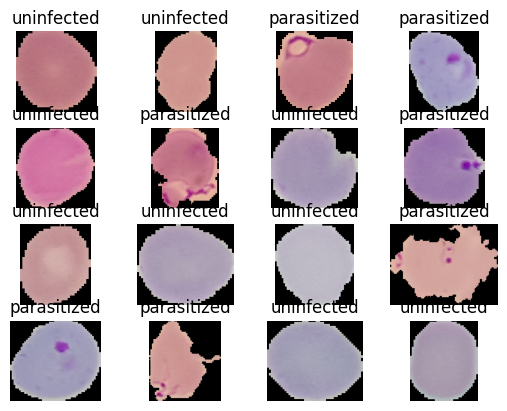

In [60]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

# Data Processing

In [61]:
IM_SIZE = 224
def resize_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [62]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [63]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [64]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

# Model creation

In [65]:
model = tf.keras.Sequential([
                            InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

                            Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
                            BatchNormalization(),
                            MaxPool2D(pool_size=2, strides=2),

                            Flatten(),

                            Dense(1000, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(100, activation='sigmoid'),
                            BatchNormalization(),
                            Dense(1, activation="sigmoid"),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_14 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_15 (Ba  (None, 109, 109, 16)      64        
 tchNormalization)                                               
                                                      

# Functional API

In [66]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_18 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_19 (Ba  (None, 109, 109, 16)      64    

In [67]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2, strides=2)(x)

x = Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)

feature_extractor = Model(func_input, output, name="feature_extractor")
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_22 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 111, 111, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_23 (Ba  (None, 109, 109, 16)

In [68]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name='Input image')

x = feature_extractor(func_input)

x = Flatten()(x)

x = Dense(1000, activation='sigmoid')(x)
x = BatchNormalization()(x)

x = Dense(100, activation='sigmoid')(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation="sigmoid")(x)

model = Model(func_input, func_output, name="Model")
model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 54, 54, 16)        1136      
 nal)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 46656)             0         
                                                                 
 dense_15 (Dense)            (None, 1000)              46657000  
                                                                 
 batch_normalization_24 (Ba  (None, 1000)              4000      
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (None, 100)               100100

# Model Subclassing

In [69]:
class FeatureExtractor(Layer):
  def __init__(self, filters, kernel_size, strides, padding, activation, pool_size,):
    super(FeatureExtractor, self).__init__()

    self.conv_1 = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size=pool_size, strides=2*strides)

    self.conv_2 = Conv2D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2 = MaxPool2D(pool_size=pool_size, strides=2*strides)

  def call(self, x):

    x = self.conv_1(x)
    x = self.batch_1(x)
    x = self.pool_1(x)

    x = self.conv_2(x)
    x = self.batch_2(x)
    x = self.pool_2(x)

    return x

feature_sub_classed = FeatureExtractor(8, 3, 1, "valid", "relu", 2)

# Metrics

In [92]:
metrics = [BinaryAccuracy(name="accuracy"), TruePositives(name='tp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
           FalsePositives(name='fp'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

# CallBacks

In [82]:
# Callback
class LossCallback(Callback):
  def on_epoch_end(self, epoch, logs):
    print("\n For Epoch Number {} the model has a loss of {} ".format(epoch+1, logs["loss"]))

  def on_batch_end(self, batch, logs):
    print("\n For Batch Number {} the model has a loss of {} ".format(batch+1, logs))

In [86]:
# CSVLogger
csvlogger = CSVLogger(
    'logs.csv', separator=',', append=False
)

In [89]:
# EarlyStopping
earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [99]:
# Learning rate schedular
def scheduler(epoch, lr):
  if epoch < 3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrSchedular = LearningRateScheduler(scheduler, verbose=1)

In [103]:
# Model checkpointing
checkPoint = ModelCheckpoint(
    'checkpoint/',
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto',
    save_freq=3,
)

In [93]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)

# Training

In [105]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, verbose=1,
                    callbacks=[csvlogger, earlystopping, lrSchedular, checkPoint])


Epoch 1: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/10
  2/689 [..............................] - ETA: 36s - loss: 0.6950 - accuracy: 0.4844 - tp: 0.0000e+00 - tn: 31.0000 - fn: 33.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 

  5/689 [..............................] - ETA: 35s - loss: 0.6959 - accuracy: 0.4688 - tp: 0.0000e+00 - tn: 75.0000 - fn: 85.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4875

  8/689 [..............................] - ETA: 34s - loss: 0.6958 - accuracy: 0.4609 - tp: 0.0000e+00 - tn: 118.0000 - fn: 138.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5020

 11/689 [..............................] - ETA: 33s - loss: 0.6953 - accuracy: 0.4602 - tp: 44.0000 - tn: 118.0000 - fn: 138.0000 - fp: 52.0000 - precision: 0.4583 - recall: 0.2418 - auc: 0.4669

 14/689 [..............................] - ETA: 33s - loss: 0.6941 - accuracy: 0.4888 - tp: 101.0000 - tn: 118.0000 - fn: 138.0000 - fp: 91.0000 - precision: 0.5260 - recall: 0.4226 - auc: 0.5022

 17/689 [..............................] - ETA: 32s - loss: 0.6953 - accuracy: 0.4816 - tp: 144.0000 - tn: 118.0000 - fn: 138.0000 - fp: 144.0000 - precision: 0.5000 - recall: 0.5106 - auc: 0.4753

 20/689 [..............................] - ETA: 32s - loss: 0.6957 - accuracy: 0.4781 - tp: 188.0000 - tn: 118.0000 - fn: 138.0000 - fp: 196.0000 - precision: 0.4896 - recall: 0.5767 - auc: 0.4666

 23/689 [>.............................] - ETA: 32s - loss: 0.6953 - accuracy: 0.4810 - tp: 221.0000 - tn: 133.0000 - fn: 155.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.5878 - auc: 0.4707

 26/689 [>.............................] - ETA: 32s - loss: 0.6950 - accuracy: 0.4856 - tp: 221.0000 - tn: 183.0000 - fn: 201.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.5237 - auc: 0.4754

 29/689 [>.............................] - ETA: 32s - loss: 0.6947 - accuracy: 0.4903 - tp: 221.0000 - tn: 234.0000 - fn: 246.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.4732 - auc: 0.4815

 32/689 [>.............................] - ETA: 32s - loss: 0.6951 - accuracy: 0.4814 - tp: 221.0000 - tn: 272.0000 - fn: 304.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.4210 - auc: 0.4721

 35/689 [>.............................] - ETA: 33s - loss: 0.6951 - accuracy: 0.4804 - tp: 221.0000 - tn: 317.0000 - fn: 355.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.3837 - auc: 0.4726

 38/689 [>.............................] - ETA: 34s - loss: 0.6951 - accuracy: 0.4753 - tp: 221.0000 - tn: 357.0000 - fn: 411.0000 - fp: 227.0000 - precision: 0.4933 - recall: 0.3497 - auc: 0.4740

 41/689 [>.............................] - ETA: 34s - loss: 0.6950 - accuracy: 0.4764 - tp: 256.0000 - tn: 369.0000 - fn: 431.0000 - fp: 256.0000 - precision: 0.5000 - recall: 0.3726 - auc: 0.4767

 44/689 [>.............................] - ETA: 35s - loss: 0.6946 - accuracy: 0.4808 - tp: 308.0000 - tn: 369.0000 - fn: 431.0000 - fp: 300.0000 - precision: 0.5066 - recall: 0.4168 - auc: 0.4806

 47/689 [=>............................] - ETA: 37s - loss: 0.6944 - accuracy: 0.4840 - tp: 359.0000 - tn: 369.0000 - fn: 431.0000 - fp: 345.0000 - precision: 0.5099 - recall: 0.4544 - auc: 0.4837

 50/689 [=>............................] - ETA: 38s - loss: 0.6954 - accuracy: 0.4825 - tp: 403.0000 - tn: 369.0000 - fn: 431.0000 - fp: 397.0000 - precision: 0.5038 - recall: 0.4832 - auc: 0.4774

 53/689 [=>............................] - ETA: 38s - loss: 0.6950 - accuracy: 0.4864 - tp: 456.0000 - tn: 369.0000 - fn: 431.0000 - fp: 440.0000 - precision: 0.5089 - recall: 0.5141 - auc: 0.4805

 56/689 [=>............................] - ETA: 39s - loss: 0.6949 - accuracy: 0.4883 - tp: 506.0000 - tn: 369.0000 - fn: 431.0000 - fp: 486.0000 - precision: 0.5101 - recall: 0.5400 - auc: 0.4814

 59/689 [=>............................] - ETA: 39s - loss: 0.6950 - accuracy: 0.4862 - tp: 549.0000 - tn: 369.0000 - fn: 431.0000 - fp: 539.0000 - precision: 0.5046 - recall: 0.5602 - auc: 0.4793

 62/689 [=>............................] - ETA: 40s - loss: 0.6950 - accuracy: 0.4854 - tp: 594.0000 - tn: 369.0000 - fn: 431.0000 - fp: 590.0000 - precision: 0.5017 - recall: 0.5795 - auc: 0.4795

 65/689 [=>............................] - ETA: 40s - loss: 0.6949 - accuracy: 0.4889 - tp: 648.0000 - tn: 369.0000 - fn: 431.0000 - fp: 632.0000 - precision: 0.5063 - recall: 0.6006 - auc: 0.4795

 68/689 [=>............................] - ETA: 40s - loss: 0.6948 - accuracy: 0.4903 - tp: 698.0000 - tn: 369.0000 - fn: 431.0000 - fp: 678.0000 - precision: 0.5073 - recall: 0.6182 - auc: 0.4800

 71/689 [==>...........................] - ETA: 40s - loss: 0.6947 - accuracy: 0.4916 - tp: 748.0000 - tn: 369.0000 - fn: 431.0000 - fp: 724.0000 - precision: 0.5082 - recall: 0.6344 - auc: 0.4804

 74/689 [==>...........................] - ETA: 40s - loss: 0.6946 - accuracy: 0.4937 - tp: 800.0000 - tn: 369.0000 - fn: 431.0000 - fp: 768.0000 - precision: 0.5102 - recall: 0.6499 - auc: 0.4811

 77/689 [==>...........................] - ETA: 40s - loss: 0.6945 - accuracy: 0.4947 - tp: 850.0000 - tn: 369.0000 - fn: 431.0000 - fp: 814.0000 - precision: 0.5108 - recall: 0.6635 - auc: 0.4814

 80/689 [==>...........................] - ETA: 41s - loss: 0.6944 - accuracy: 0.4969 - tp: 903.0000 - tn: 369.0000 - fn: 431.0000 - fp: 857.0000 - precision: 0.5131 - recall: 0.6769 - auc: 0.4828

 83/689 [==>...........................] - ETA: 41s - loss: 0.6945 - accuracy: 0.4959 - tp: 948.0000 - tn: 369.0000 - fn: 431.0000 - fp: 908.0000 - precision: 0.5108 - recall: 0.6875 - auc: 0.4807

 86/689 [==>...........................] - ETA: 41s - loss: 0.6945 - accuracy: 0.4956 - tp: 995.0000 - tn: 369.0000 - fn: 431.0000 - fp: 957.0000 - precision: 0.5097 - recall: 0.6978 - auc: 0.4805

 89/689 [==>...........................] - ETA: 41s - loss: 0.6945 - accuracy: 0.4954 - tp: 1042.0000 - tn: 369.0000 - fn: 431.0000 - fp: 1006.0000 - precision: 0.5088 - recall: 0.7074 - auc: 0.4803

 92/689 [===>..........................] - ETA: 41s - loss: 0.6945 - accuracy: 0.4939 - tp: 1085.0000 - tn: 369.0000 - fn: 431.0000 - fp: 1059.0000 - precision: 0.5061 - recall: 0.7157 - auc: 0.4808

 95/689 [===>..........................] - ETA: 41s - loss: 0.6945 - accuracy: 0.4951 - tp: 1102.0000 - tn: 403.0000 - fn: 461.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.7051 - auc: 0.4819

 98/689 [===>..........................] - ETA: 40s - loss: 0.6944 - accuracy: 0.4971 - tp: 1102.0000 - tn: 457.0000 - fn: 503.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6866 - auc: 0.4850

101/689 [===>..........................] - ETA: 40s - loss: 0.6944 - accuracy: 0.4975 - tp: 1102.0000 - tn: 506.0000 - fn: 550.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6671 - auc: 0.4861

103/689 [===>..........................] - ETA: 39s - loss: 0.6943 - accuracy: 0.4982 - tp: 1102.0000 - tn: 540.0000 - fn: 580.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6552 - auc: 0.4875

107/689 [===>..........................] - ETA: 39s - loss: 0.6943 - accuracy: 0.4988 - tp: 1102.0000 - tn: 606.0000 - fn: 642.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6319 - auc: 0.4891

110/689 [===>..........................] - ETA: 38s - loss: 0.6943 - accuracy: 0.4989 - tp: 1102.0000 - tn: 654.0000 - fn: 690.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6150 - auc: 0.4897

113/689 [===>..........................] - ETA: 38s - loss: 0.6942 - accuracy: 0.5008 - tp: 1102.0000 - tn: 709.0000 - fn: 731.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.6012 - auc: 0.4927

115/689 [====>.........................] - ETA: 37s - loss: 0.6942 - accuracy: 0.5003 - tp: 1102.0000 - tn: 739.0000 - fn: 765.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5903 - auc: 0.4921

119/689 [====>.........................] - ETA: 37s - loss: 0.6942 - accuracy: 0.5003 - tp: 1102.0000 - tn: 803.0000 - fn: 829.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5707 - auc: 0.4927

121/689 [====>.........................] - ETA: 36s - loss: 0.6941 - accuracy: 0.5015 - tp: 1102.0000 - tn: 840.0000 - fn: 856.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5628 - auc: 0.4951

125/689 [====>.........................] - ETA: 36s - loss: 0.6939 - accuracy: 0.5040 - tp: 1102.0000 - tn: 914.0000 - fn: 910.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5477 - auc: 0.4998

127/689 [====>.........................] - ETA: 35s - loss: 0.6939 - accuracy: 0.5037 - tp: 1102.0000 - tn: 945.0000 - fn: 943.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5389 - auc: 0.4994

131/689 [====>.........................] - ETA: 35s - loss: 0.6939 - accuracy: 0.5041 - tp: 1102.0000 - tn: 1011.0000 - fn: 1005.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5230 - auc: 0.5004

134/689 [====>.........................] - ETA: 34s - loss: 0.6938 - accuracy: 0.5044 - tp: 1102.0000 - tn: 1061.0000 - fn: 1051.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.5118 - auc: 0.5013

137/689 [====>.........................] - ETA: 34s - loss: 0.6940 - accuracy: 0.5023 - tp: 1102.0000 - tn: 1100.0000 - fn: 1108.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4986 - auc: 0.4975

140/689 [=====>........................] - ETA: 34s - loss: 0.6940 - accuracy: 0.5031 - tp: 1102.0000 - tn: 1152.0000 - fn: 1152.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4889 - auc: 0.4988

143/689 [=====>........................] - ETA: 33s - loss: 0.6940 - accuracy: 0.5031 - tp: 1102.0000 - tn: 1200.0000 - fn: 1200.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4787 - auc: 0.4989

146/689 [=====>........................] - ETA: 33s - loss: 0.6940 - accuracy: 0.5032 - tp: 1102.0000 - tn: 1249.0000 - fn: 1247.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4691 - auc: 0.4991

149/689 [=====>........................] - ETA: 33s - loss: 0.6941 - accuracy: 0.5015 - tp: 1102.0000 - tn: 1289.0000 - fn: 1303.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4582 - auc: 0.4974

152/689 [=====>........................] - ETA: 32s - loss: 0.6940 - accuracy: 0.5010 - tp: 1102.0000 - tn: 1335.0000 - fn: 1353.0000 - fp: 1074.0000 - precision: 0.5064 - recall: 0.4489 - auc: 0.4975

155/689 [=====>........................] - ETA: 32s - loss: 0.6940 - accuracy: 0.5018 - tp: 1135.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1105.0000 - precision: 0.5067 - recall: 0.4538 - auc: 0.4976

158/689 [=====>........................] - ETA: 32s - loss: 0.6940 - accuracy: 0.5012 - tp: 1180.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1156.0000 - precision: 0.5051 - recall: 0.4635 - auc: 0.4972

160/689 [=====>........................] - ETA: 31s - loss: 0.6940 - accuracy: 0.5014 - tp: 1213.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1187.0000 - precision: 0.5054 - recall: 0.4703 - auc: 0.4974

164/689 [======>.......................] - ETA: 31s - loss: 0.6940 - accuracy: 0.5023 - tp: 1282.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1246.0000 - precision: 0.5071 - recall: 0.4841 - auc: 0.4977

167/689 [======>.......................] - ETA: 31s - loss: 0.6940 - accuracy: 0.5011 - tp: 1324.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1300.0000 - precision: 0.5046 - recall: 0.4922 - auc: 0.4970

170/689 [======>.......................] - ETA: 30s - loss: 0.6940 - accuracy: 0.5013 - tp: 1373.0000 - tn: 1354.0000 - fn: 1366.0000 - fp: 1347.0000 - precision: 0.5048 - recall: 0.5013 - auc: 0.4971

173/689 [======>.......................] - ETA: 30s - loss: 0.6940 - accuracy: 0.4996 - tp: 1385.0000 - tn: 1381.0000 - fn: 1403.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4968 - auc: 0.4972

175/689 [======>.......................] - ETA: 30s - loss: 0.6940 - accuracy: 0.5000 - tp: 1385.0000 - tn: 1415.0000 - fn: 1433.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4915 - auc: 0.4972

179/689 [======>.......................] - ETA: 30s - loss: 0.6939 - accuracy: 0.5007 - tp: 1385.0000 - tn: 1483.0000 - fn: 1493.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4812 - auc: 0.4974

181/689 [======>.......................] - ETA: 29s - loss: 0.6939 - accuracy: 0.5002 - tp: 1385.0000 - tn: 1512.0000 - fn: 1528.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4755 - auc: 0.4973

185/689 [=======>......................] - ETA: 29s - loss: 0.6939 - accuracy: 0.5010 - tp: 1385.0000 - tn: 1581.0000 - fn: 1587.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4660 - auc: 0.4976

188/689 [=======>......................] - ETA: 29s - loss: 0.6939 - accuracy: 0.5003 - tp: 1385.0000 - tn: 1625.0000 - fn: 1639.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4580 - auc: 0.4972

191/689 [=======>......................] - ETA: 29s - loss: 0.6939 - accuracy: 0.4998 - tp: 1385.0000 - tn: 1670.0000 - fn: 1690.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4504 - auc: 0.4969

194/689 [=======>......................] - ETA: 28s - loss: 0.6940 - accuracy: 0.4989 - tp: 1385.0000 - tn: 1712.0000 - fn: 1744.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4426 - auc: 0.4966

197/689 [=======>......................] - ETA: 28s - loss: 0.6940 - accuracy: 0.4986 - tp: 1385.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4357 - auc: 0.4966

200/689 [=======>......................] - ETA: 28s - loss: 0.6940 - accuracy: 0.4983 - tp: 1431.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1417.0000 - precision: 0.5025 - recall: 0.4437 - auc: 0.4961

203/689 [=======>......................] - ETA: 28s - loss: 0.6939 - accuracy: 0.4991 - tp: 1484.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1460.0000 - precision: 0.5041 - recall: 0.4527 - auc: 0.4967

205/689 [=======>......................] - ETA: 27s - loss: 0.6939 - accuracy: 0.5000 - tp: 1522.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1486.0000 - precision: 0.5060 - recall: 0.4590 - auc: 0.4977

209/689 [========>.....................] - ETA: 27s - loss: 0.6940 - accuracy: 0.4985 - tp: 1576.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1560.0000 - precision: 0.5026 - recall: 0.4677 - auc: 0.4956

212/689 [========>.....................] - ETA: 27s - loss: 0.6940 - accuracy: 0.4978 - tp: 1619.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1613.0000 - precision: 0.5009 - recall: 0.4744 - auc: 0.4946

214/689 [========>.....................] - ETA: 27s - loss: 0.6940 - accuracy: 0.4968 - tp: 1644.0000 - tn: 1758.0000 - fn: 1794.0000 - fp: 1652.0000 - precision: 0.4988 - recall: 0.4782 - auc: 0.4940

217/689 [========>.....................] - ETA: 26s - loss: 0.6940 - accuracy: 0.4968 - tp: 1658.0000 - tn: 1792.0000 - fn: 1824.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4762 - auc: 0.4939

221/689 [========>.....................] - ETA: 26s - loss: 0.6940 - accuracy: 0.4960 - tp: 1658.0000 - tn: 1850.0000 - fn: 1894.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4668 - auc: 0.4934

223/689 [========>.....................] - ETA: 26s - loss: 0.6940 - accuracy: 0.4954 - tp: 1658.0000 - tn: 1877.0000 - fn: 1931.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4620 - auc: 0.4929

227/689 [========>.....................] - ETA: 26s - loss: 0.6940 - accuracy: 0.4960 - tp: 1658.0000 - tn: 1945.0000 - fn: 1991.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4544 - auc: 0.4934

230/689 [=========>....................] - ETA: 25s - loss: 0.6940 - accuracy: 0.4971 - tp: 1658.0000 - tn: 2001.0000 - fn: 2031.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4494 - auc: 0.4938

232/689 [=========>....................] - ETA: 25s - loss: 0.6940 - accuracy: 0.4970 - tp: 1658.0000 - tn: 2032.0000 - fn: 2064.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4455 - auc: 0.4937

236/689 [=========>....................] - ETA: 25s - loss: 0.6940 - accuracy: 0.4968 - tp: 1658.0000 - tn: 2094.0000 - fn: 2130.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4377 - auc: 0.4936

239/689 [=========>....................] - ETA: 25s - loss: 0.6940 - accuracy: 0.4970 - tp: 1658.0000 - tn: 2143.0000 - fn: 2177.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4323 - auc: 0.4937

242/689 [=========>....................] - ETA: 24s - loss: 0.6940 - accuracy: 0.4969 - tp: 1658.0000 - tn: 2190.0000 - fn: 2226.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4269 - auc: 0.4937

244/689 [=========>....................] - ETA: 24s - loss: 0.6939 - accuracy: 0.4969 - tp: 1658.0000 - tn: 2222.0000 - fn: 2258.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4234 - auc: 0.4937

247/689 [=========>....................] - ETA: 24s - loss: 0.6939 - accuracy: 0.4966 - tp: 1658.0000 - tn: 2267.0000 - fn: 2309.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4179 - auc: 0.4937

250/689 [=========>....................] - ETA: 24s - loss: 0.6939 - accuracy: 0.4965 - tp: 1658.0000 - tn: 2314.0000 - fn: 2358.0000 - fp: 1670.0000 - precision: 0.4982 - recall: 0.4128 - auc: 0.4938

254/689 [==========>...................] - ETA: 24s - loss: 0.6939 - accuracy: 0.4958 - tp: 1716.0000 - tn: 2314.0000 - fn: 2358.0000 - fp: 1740.0000 - precision: 0.4965 - recall: 0.4212 - auc: 0.4932

256/689 [==========>...................] - ETA: 24s - loss: 0.6939 - accuracy: 0.4960 - tp: 1733.0000 - tn: 2330.0000 - fn: 2374.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.4220 - auc: 0.4932

260/689 [==========>...................] - ETA: 23s - loss: 0.6939 - accuracy: 0.4959 - tp: 1733.0000 - tn: 2393.0000 - fn: 2439.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.4154 - auc: 0.4929

263/689 [==========>...................] - ETA: 23s - loss: 0.6939 - accuracy: 0.4968 - tp: 1733.0000 - tn: 2448.0000 - fn: 2480.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.4113 - auc: 0.4932

266/689 [==========>...................] - ETA: 23s - loss: 0.6939 - accuracy: 0.4965 - tp: 1733.0000 - tn: 2493.0000 - fn: 2531.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.4064 - auc: 0.4930

268/689 [==========>...................] - ETA: 23s - loss: 0.6939 - accuracy: 0.4964 - tp: 1733.0000 - tn: 2524.0000 - fn: 2564.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.4033 - auc: 0.4929

271/689 [==========>...................] - ETA: 23s - loss: 0.6939 - accuracy: 0.4958 - tp: 1733.0000 - tn: 2567.0000 - fn: 2617.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3984 - auc: 0.4925

275/689 [==========>...................] - ETA: 22s - loss: 0.6939 - accuracy: 0.4963 - tp: 1733.0000 - tn: 2634.0000 - fn: 2678.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3929 - auc: 0.4926

278/689 [===========>..................] - ETA: 22s - loss: 0.6939 - accuracy: 0.4965 - tp: 1733.0000 - tn: 2684.0000 - fn: 2724.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3888 - auc: 0.4927

281/689 [===========>..................] - ETA: 22s - loss: 0.6939 - accuracy: 0.4966 - tp: 1733.0000 - tn: 2732.0000 - fn: 2772.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3847 - auc: 0.4927

284/689 [===========>..................] - ETA: 22s - loss: 0.6939 - accuracy: 0.4963 - tp: 1733.0000 - tn: 2777.0000 - fn: 2823.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3804 - auc: 0.4927

287/689 [===========>..................] - ETA: 22s - loss: 0.6939 - accuracy: 0.4962 - tp: 1733.0000 - tn: 2824.0000 - fn: 2872.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3763 - auc: 0.4927

290/689 [===========>..................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4971 - tp: 1733.0000 - tn: 2880.0000 - fn: 2912.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3731 - auc: 0.4923

293/689 [===========>..................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4971 - tp: 1733.0000 - tn: 2928.0000 - fn: 2960.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3693 - auc: 0.4923

296/689 [===========>..................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4974 - tp: 1733.0000 - tn: 2978.0000 - fn: 3006.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3657 - auc: 0.4924

299/689 [============>.................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4972 - tp: 1733.0000 - tn: 3024.0000 - fn: 3056.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3619 - auc: 0.4924

301/689 [============>.................] - ETA: 21s - loss: 0.6939 - accuracy: 0.4969 - tp: 1733.0000 - tn: 3053.0000 - fn: 3091.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3592 - auc: 0.4923

305/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4971 - tp: 1733.0000 - tn: 3119.0000 - fn: 3153.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3547 - auc: 0.4924

308/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4981 - tp: 1733.0000 - tn: 3176.0000 - fn: 3192.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3519 - auc: 0.4926

311/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4975 - tp: 1733.0000 - tn: 3218.0000 - fn: 3246.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3481 - auc: 0.4921

313/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4976 - tp: 1733.0000 - tn: 3251.0000 - fn: 3277.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3459 - auc: 0.4922

317/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4972 - tp: 1733.0000 - tn: 3311.0000 - fn: 3345.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3413 - auc: 0.4918

320/689 [============>.................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4970 - tp: 1733.0000 - tn: 3356.0000 - fn: 3396.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3379 - auc: 0.4918

323/689 [=============>................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4969 - tp: 1733.0000 - tn: 3403.0000 - fn: 3445.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3347 - auc: 0.4918

326/689 [=============>................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4973 - tp: 1733.0000 - tn: 3455.0000 - fn: 3489.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3319 - auc: 0.4919

329/689 [=============>................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4986 - tp: 1733.0000 - tn: 3516.0000 - fn: 3524.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3297 - auc: 0.4920

332/689 [=============>................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4986 - tp: 1733.0000 - tn: 3564.0000 - fn: 3572.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3267 - auc: 0.4920

335/689 [=============>................] - ETA: 20s - loss: 0.6938 - accuracy: 0.4984 - tp: 1733.0000 - tn: 3610.0000 - fn: 3622.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3236 - auc: 0.4918

338/689 [=============>................] - ETA: 19s - loss: 0.6938 - accuracy: 0.4982 - tp: 1733.0000 - tn: 3655.0000 - fn: 3673.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3206 - auc: 0.4916

341/689 [=============>................] - ETA: 19s - loss: 0.6938 - accuracy: 0.4976 - tp: 1733.0000 - tn: 3697.0000 - fn: 3727.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3174 - auc: 0.4911

344/689 [=============>................] - ETA: 19s - loss: 0.6938 - accuracy: 0.4982 - tp: 1733.0000 - tn: 3751.0000 - fn: 3769.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3150 - auc: 0.4911

347/689 [==============>...............] - ETA: 19s - loss: 0.6938 - accuracy: 0.4988 - tp: 1733.0000 - tn: 3806.0000 - fn: 3810.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3126 - auc: 0.4912

350/689 [==============>...............] - ETA: 19s - loss: 0.6937 - accuracy: 0.4995 - tp: 1733.0000 - tn: 3861.0000 - fn: 3851.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3104 - auc: 0.4918

353/689 [==============>...............] - ETA: 19s - loss: 0.6937 - accuracy: 0.4995 - tp: 1733.0000 - tn: 3909.0000 - fn: 3899.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3077 - auc: 0.4919

356/689 [==============>...............] - ETA: 19s - loss: 0.6938 - accuracy: 0.4989 - tp: 1733.0000 - tn: 3950.0000 - fn: 3954.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3047 - auc: 0.4913

359/689 [==============>...............] - ETA: 19s - loss: 0.6938 - accuracy: 0.4984 - tp: 1733.0000 - tn: 3993.0000 - fn: 4007.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3019 - auc: 0.4909

361/689 [==============>...............] - ETA: 19s - loss: 0.6938 - accuracy: 0.4984 - tp: 1733.0000 - tn: 4024.0000 - fn: 4040.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.3002 - auc: 0.4908

365/689 [==============>...............] - ETA: 18s - loss: 0.6938 - accuracy: 0.4986 - tp: 1733.0000 - tn: 4091.0000 - fn: 4101.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2971 - auc: 0.4907

368/689 [===============>..............] - ETA: 18s - loss: 0.6938 - accuracy: 0.4989 - tp: 1733.0000 - tn: 4142.0000 - fn: 4146.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2948 - auc: 0.4907

371/689 [===============>..............] - ETA: 18s - loss: 0.6938 - accuracy: 0.4989 - tp: 1733.0000 - tn: 4190.0000 - fn: 4194.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2924 - auc: 0.4907

374/689 [===============>..............] - ETA: 18s - loss: 0.6938 - accuracy: 0.4988 - tp: 1733.0000 - tn: 4237.0000 - fn: 4243.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2900 - auc: 0.4907

377/689 [===============>..............] - ETA: 18s - loss: 0.6938 - accuracy: 0.4987 - tp: 1733.0000 - tn: 4283.0000 - fn: 4293.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2876 - auc: 0.4908

380/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4985 - tp: 1733.0000 - tn: 4329.0000 - fn: 4343.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2852 - auc: 0.4908

383/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4988 - tp: 1733.0000 - tn: 4380.0000 - fn: 4388.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2831 - auc: 0.4905

386/689 [===============>..............] - ETA: 17s - loss: 0.6937 - accuracy: 0.4990 - tp: 1733.0000 - tn: 4431.0000 - fn: 4433.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2811 - auc: 0.4903

388/689 [===============>..............] - ETA: 17s - loss: 0.6937 - accuracy: 0.4992 - tp: 1733.0000 - tn: 4465.0000 - fn: 4463.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2797 - auc: 0.4903

392/689 [================>.............] - ETA: 17s - loss: 0.6937 - accuracy: 0.4990 - tp: 1733.0000 - tn: 4527.0000 - fn: 4529.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2767 - auc: 0.4904

395/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4990 - tp: 1733.0000 - tn: 4574.0000 - fn: 4578.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2746 - auc: 0.4904

398/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4983 - tp: 1733.0000 - tn: 4613.0000 - fn: 4635.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2721 - auc: 0.4904

400/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4979 - tp: 1733.0000 - tn: 4640.0000 - fn: 4672.0000 - fp: 1755.0000 - precision: 0.4968 - recall: 0.2706 - auc: 0.4907

404/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4986 - tp: 1749.0000 - tn: 4697.0000 - fn: 4711.0000 - fp: 1771.0000 - precision: 0.4969 - recall: 0.2707 - auc: 0.4902

406/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4985 - tp: 1780.0000 - tn: 4697.0000 - fn: 4711.0000 - fp: 1804.0000 - precision: 0.4967 - recall: 0.2742 - auc: 0.4902

410/689 [================>.............] - ETA: 16s - loss: 0.6937 - accuracy: 0.4987 - tp: 1846.0000 - tn: 4697.0000 - fn: 4711.0000 - fp: 1866.0000 - precision: 0.4973 - recall: 0.2815 - auc: 0.4904

413/689 [================>.............] - ETA: 15s - loss: 0.6937 - accuracy: 0.4985 - tp: 1891.0000 - tn: 4697.0000 - fn: 4711.0000 - fp: 1917.0000 - precision: 0.4966 - recall: 0.2864 - auc: 0.4903

416/689 [=================>............] - ETA: 15s - loss: 0.6937 - accuracy: 0.4985 - tp: 1939.0000 - tn: 4697.0000 - fn: 4711.0000 - fp: 1965.0000 - precision: 0.4967 - recall: 0.2916 - auc: 0.4904

419/689 [=================>............] - ETA: 15s - loss: 0.6937 - accuracy: 0.4980 - tp: 1971.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 1997.0000 - precision: 0.4967 - recall: 0.2940 - auc: 0.4909

421/689 [=================>............] - ETA: 15s - loss: 0.6937 - accuracy: 0.4978 - tp: 2000.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2032.0000 - precision: 0.4960 - recall: 0.2970 - auc: 0.4907

425/689 [=================>............] - ETA: 15s - loss: 0.6937 - accuracy: 0.4983 - tp: 2071.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2089.0000 - precision: 0.4978 - recall: 0.3043 - auc: 0.4912

427/689 [=================>............] - ETA: 14s - loss: 0.6937 - accuracy: 0.4981 - tp: 2100.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2124.0000 - precision: 0.4972 - recall: 0.3073 - auc: 0.4910

431/689 [=================>............] - ETA: 14s - loss: 0.6937 - accuracy: 0.4980 - tp: 2163.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2189.0000 - precision: 0.4970 - recall: 0.3136 - auc: 0.4911

433/689 [=================>............] - ETA: 14s - loss: 0.6937 - accuracy: 0.4986 - tp: 2203.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2213.0000 - precision: 0.4989 - recall: 0.3176 - auc: 0.4919

437/689 [==================>...........] - ETA: 14s - loss: 0.6937 - accuracy: 0.4985 - tp: 2265.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2279.0000 - precision: 0.4985 - recall: 0.3236 - auc: 0.4918

440/689 [==================>...........] - ETA: 14s - loss: 0.6937 - accuracy: 0.4984 - tp: 2311.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2329.0000 - precision: 0.4981 - recall: 0.3280 - auc: 0.4916

442/689 [==================>...........] - ETA: 13s - loss: 0.6937 - accuracy: 0.4984 - tp: 2344.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2360.0000 - precision: 0.4983 - recall: 0.3312 - auc: 0.4918

446/689 [==================>...........] - ETA: 13s - loss: 0.6937 - accuracy: 0.4982 - tp: 2404.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2428.0000 - precision: 0.4975 - recall: 0.3368 - auc: 0.4915

449/689 [==================>...........] - ETA: 13s - loss: 0.6937 - accuracy: 0.4982 - tp: 2452.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2476.0000 - precision: 0.4976 - recall: 0.3412 - auc: 0.4916

452/689 [==================>...........] - ETA: 13s - loss: 0.6937 - accuracy: 0.4979 - tp: 2496.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2528.0000 - precision: 0.4968 - recall: 0.3452 - auc: 0.4913

455/689 [==================>...........] - ETA: 13s - loss: 0.6937 - accuracy: 0.4984 - tp: 2550.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2570.0000 - precision: 0.4980 - recall: 0.3501 - auc: 0.4919

458/689 [==================>...........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4988 - tp: 2605.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2611.0000 - precision: 0.4994 - recall: 0.3550 - auc: 0.4926

461/689 [===================>..........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4982 - tp: 2643.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2669.0000 - precision: 0.4976 - recall: 0.3583 - auc: 0.4918

463/689 [===================>..........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4984 - tp: 2678.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2698.0000 - precision: 0.4981 - recall: 0.3613 - auc: 0.4921

467/689 [===================>..........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4983 - tp: 2740.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2764.0000 - precision: 0.4978 - recall: 0.3666 - auc: 0.4920

469/689 [===================>..........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4982 - tp: 2771.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2797.0000 - precision: 0.4977 - recall: 0.3692 - auc: 0.4920

472/689 [===================>..........] - ETA: 12s - loss: 0.6937 - accuracy: 0.4984 - tp: 2822.0000 - tn: 4706.0000 - fn: 4734.0000 - fp: 2842.0000 - precision: 0.4982 - recall: 0.3735 - auc: 0.4922

476/689 [===================>..........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4982 - tp: 2865.0000 - tn: 4723.0000 - fn: 4749.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3763 - auc: 0.4920

479/689 [===================>..........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4984 - tp: 2865.0000 - tn: 4774.0000 - fn: 4794.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3741 - auc: 0.4920

481/689 [===================>..........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4981 - tp: 2865.0000 - tn: 4802.0000 - fn: 4830.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3723 - auc: 0.4921

484/689 [====================>.........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4981 - tp: 2865.0000 - tn: 4850.0000 - fn: 4878.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3700 - auc: 0.4922

488/689 [====================>.........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4982 - tp: 2865.0000 - tn: 4915.0000 - fn: 4941.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3670 - auc: 0.4922

490/689 [====================>.........] - ETA: 11s - loss: 0.6937 - accuracy: 0.4978 - tp: 2865.0000 - tn: 4941.0000 - fn: 4979.0000 - fp: 2895.0000 - precision: 0.4974 - recall: 0.3652 - auc: 0.4925

494/689 [====================>.........] - ETA: 10s - loss: 0.6937 - accuracy: 0.4977 - tp: 2881.0000 - tn: 4986.0000 - fn: 5030.0000 - fp: 2911.0000 - precision: 0.4974 - recall: 0.3642 - auc: 0.4926

497/689 [====================>.........] - ETA: 10s - loss: 0.6937 - accuracy: 0.4970 - tp: 2918.0000 - tn: 4986.0000 - fn: 5030.0000 - fp: 2970.0000 - precision: 0.4956 - recall: 0.3671 - auc: 0.4923

500/689 [====================>.........] - ETA: 10s - loss: 0.6937 - accuracy: 0.4966 - tp: 2933.0000 - tn: 5013.0000 - fn: 5067.0000 - fp: 2987.0000 - precision: 0.4954 - recall: 0.3666 - auc: 0.4925

503/689 [====================>.........] - ETA: 10s - loss: 0.6936 - accuracy: 0.4968 - tp: 2933.0000 - tn: 5063.0000 - fn: 5113.0000 - fp: 2987.0000 - precision: 0.4954 - recall: 0.3645 - auc: 0.4924

506/689 [=====================>........] - ETA: 10s - loss: 0.6936 - accuracy: 0.4964 - tp: 2933.0000 - tn: 5104.0000 - fn: 5168.0000 - fp: 2987.0000 - precision: 0.4954 - recall: 0.3621 - auc: 0.4927

509/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4963 - tp: 2966.0000 - tn: 5117.0000 - fn: 5187.0000 - fp: 3018.0000 - precision: 0.4957 - recall: 0.3638 - auc: 0.4929 

512/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4962 - tp: 3013.0000 - tn: 5117.0000 - fn: 5187.0000 - fp: 3067.0000 - precision: 0.4956 - recall: 0.3674 - auc: 0.4929

515/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4957 - tp: 3052.0000 - tn: 5117.0000 - fn: 5187.0000 - fp: 3124.0000 - precision: 0.4942 - recall: 0.3704 - auc: 0.4922

518/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4951 - tp: 3090.0000 - tn: 5117.0000 - fn: 5187.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3733 - auc: 0.4920

521/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4952 - tp: 3090.0000 - tn: 5166.0000 - fn: 5234.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3712 - auc: 0.4920

524/689 [=====================>........] - ETA: 9s - loss: 0.6936 - accuracy: 0.4955 - tp: 3090.0000 - tn: 5218.0000 - fn: 5278.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3693 - auc: 0.4921

527/689 [=====================>........] - ETA: 8s - loss: 0.6936 - accuracy: 0.4957 - tp: 3090.0000 - tn: 5269.0000 - fn: 5323.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3673 - auc: 0.4922

530/689 [======================>.......] - ETA: 8s - loss: 0.6936 - accuracy: 0.4957 - tp: 3090.0000 - tn: 5317.0000 - fn: 5371.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3652 - auc: 0.4922

533/689 [======================>.......] - ETA: 8s - loss: 0.6936 - accuracy: 0.4954 - tp: 3090.0000 - tn: 5360.0000 - fn: 5424.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3629 - auc: 0.4918

536/689 [======================>.......] - ETA: 8s - loss: 0.6936 - accuracy: 0.4958 - tp: 3090.0000 - tn: 5414.0000 - fn: 5466.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3612 - auc: 0.4923

539/689 [======================>.......] - ETA: 8s - loss: 0.6936 - accuracy: 0.4955 - tp: 3090.0000 - tn: 5457.0000 - fn: 5519.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3589 - auc: 0.4919

541/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4953 - tp: 3090.0000 - tn: 5484.0000 - fn: 5556.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3574 - auc: 0.4916

545/689 [======================>.......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4952 - tp: 3090.0000 - tn: 5546.0000 - fn: 5622.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3547 - auc: 0.4915

547/689 [======================>.......] - ETA: 7s - loss: 0.6936 - accuracy: 0.4956 - tp: 3090.0000 - tn: 5585.0000 - fn: 5647.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3537 - auc: 0.4920

551/689 [======================>.......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4949 - tp: 3090.0000 - tn: 5636.0000 - fn: 5724.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3506 - auc: 0.4914

554/689 [=======================>......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4949 - tp: 3090.0000 - tn: 5683.0000 - fn: 5773.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3486 - auc: 0.4913

557/689 [=======================>......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4950 - tp: 3090.0000 - tn: 5733.0000 - fn: 5819.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3468 - auc: 0.4913

560/689 [=======================>......] - ETA: 7s - loss: 0.6936 - accuracy: 0.4955 - tp: 3090.0000 - tn: 5790.0000 - fn: 5858.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3453 - auc: 0.4911

563/689 [=======================>......] - ETA: 6s - loss: 0.6936 - accuracy: 0.4957 - tp: 3090.0000 - tn: 5841.0000 - fn: 5903.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3436 - auc: 0.4914

566/689 [=======================>......] - ETA: 6s - loss: 0.6936 - accuracy: 0.4960 - tp: 3090.0000 - tn: 5893.0000 - fn: 5947.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3419 - auc: 0.4919

568/689 [=======================>......] - ETA: 6s - loss: 0.6936 - accuracy: 0.4958 - tp: 3090.0000 - tn: 5922.0000 - fn: 5982.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3406 - auc: 0.4916

572/689 [=======================>......] - ETA: 6s - loss: 0.6937 - accuracy: 0.4958 - tp: 3090.0000 - tn: 5985.0000 - fn: 6047.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3382 - auc: 0.4916

574/689 [=======================>......] - ETA: 6s - loss: 0.6937 - accuracy: 0.4959 - tp: 3090.0000 - tn: 6019.0000 - fn: 6077.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3371 - auc: 0.4918

577/689 [========================>.....] - ETA: 6s - loss: 0.6937 - accuracy: 0.4958 - tp: 3090.0000 - tn: 6065.0000 - fn: 6127.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3353 - auc: 0.4917

580/689 [========================>.....] - ETA: 5s - loss: 0.6937 - accuracy: 0.4957 - tp: 3090.0000 - tn: 6111.0000 - fn: 6177.0000 - fp: 3182.0000 - precision: 0.4927 - recall: 0.3334 - auc: 0.4916

584/689 [========================>.....] - ETA: 5s - loss: 0.6937 - accuracy: 0.4950 - tp: 3115.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3221.0000 - precision: 0.4916 - recall: 0.3338 - auc: 0.4912

587/689 [========================>.....] - ETA: 5s - loss: 0.6936 - accuracy: 0.4956 - tp: 3174.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3258.0000 - precision: 0.4935 - recall: 0.3380 - auc: 0.4921

590/689 [========================>.....] - ETA: 5s - loss: 0.6936 - accuracy: 0.4958 - tp: 3225.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3303.0000 - precision: 0.4940 - recall: 0.3416 - auc: 0.4925

593/689 [========================>.....] - ETA: 5s - loss: 0.6937 - accuracy: 0.4956 - tp: 3268.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3356.0000 - precision: 0.4934 - recall: 0.3446 - auc: 0.4920

596/689 [========================>.....] - ETA: 5s - loss: 0.6937 - accuracy: 0.4956 - tp: 3316.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3404.0000 - precision: 0.4935 - recall: 0.3479 - auc: 0.4921

599/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4955 - tp: 3361.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3455.0000 - precision: 0.4931 - recall: 0.3509 - auc: 0.4919

602/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4953 - tp: 3405.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3507.0000 - precision: 0.4926 - recall: 0.3539 - auc: 0.4917

605/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4957 - tp: 3460.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3548.0000 - precision: 0.4937 - recall: 0.3576 - auc: 0.4922

608/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4958 - tp: 3510.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3594.0000 - precision: 0.4941 - recall: 0.3609 - auc: 0.4923

611/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4958 - tp: 3558.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3642.0000 - precision: 0.4942 - recall: 0.3640 - auc: 0.4924

614/689 [=========================>....] - ETA: 4s - loss: 0.6937 - accuracy: 0.4959 - tp: 3608.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3688.0000 - precision: 0.4945 - recall: 0.3673 - auc: 0.4926

617/689 [=========================>....] - ETA: 4s - loss: 0.6936 - accuracy: 0.4965 - tp: 3666.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3726.0000 - precision: 0.4959 - recall: 0.3710 - auc: 0.4935

620/689 [=========================>....] - ETA: 3s - loss: 0.6937 - accuracy: 0.4964 - tp: 3713.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3775.0000 - precision: 0.4959 - recall: 0.3740 - auc: 0.4935

623/689 [==========================>...] - ETA: 3s - loss: 0.6937 - accuracy: 0.4963 - tp: 3759.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3825.0000 - precision: 0.4956 - recall: 0.3768 - auc: 0.4933

626/689 [==========================>...] - ETA: 3s - loss: 0.6937 - accuracy: 0.4965 - tp: 3809.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3871.0000 - precision: 0.4960 - recall: 0.3800 - auc: 0.4935

629/689 [==========================>...] - ETA: 3s - loss: 0.6936 - accuracy: 0.4972 - tp: 3871.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3905.0000 - precision: 0.4978 - recall: 0.3838 - auc: 0.4947

632/689 [==========================>...] - ETA: 3s - loss: 0.6936 - accuracy: 0.4972 - tp: 3920.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3952.0000 - precision: 0.4980 - recall: 0.3867 - auc: 0.4949

635/689 [==========================>...] - ETA: 3s - loss: 0.6936 - accuracy: 0.4975 - tp: 3974.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 3994.0000 - precision: 0.4987 - recall: 0.3900 - auc: 0.4954

638/689 [==========================>...] - ETA: 2s - loss: 0.6936 - accuracy: 0.4978 - tp: 4027.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4037.0000 - precision: 0.4994 - recall: 0.3931 - auc: 0.4959

641/689 [==========================>...] - ETA: 2s - loss: 0.6937 - accuracy: 0.4974 - tp: 4066.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4094.0000 - precision: 0.4983 - recall: 0.3954 - auc: 0.4951

644/689 [===========================>..] - ETA: 2s - loss: 0.6937 - accuracy: 0.4974 - tp: 4115.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4141.0000 - precision: 0.4984 - recall: 0.3983 - auc: 0.4952

647/689 [===========================>..] - ETA: 2s - loss: 0.6937 - accuracy: 0.4975 - tp: 4164.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4188.0000 - precision: 0.4986 - recall: 0.4012 - auc: 0.4953

650/689 [===========================>..] - ETA: 2s - loss: 0.6937 - accuracy: 0.4976 - tp: 4214.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4234.0000 - precision: 0.4988 - recall: 0.4040 - auc: 0.4955

653/689 [===========================>..] - ETA: 2s - loss: 0.6937 - accuracy: 0.4974 - tp: 4257.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4287.0000 - precision: 0.4982 - recall: 0.4065 - auc: 0.4952

656/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4973 - tp: 4303.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4337.0000 - precision: 0.4980 - recall: 0.4091 - auc: 0.4951

659/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4970 - tp: 4344.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4392.0000 - precision: 0.4973 - recall: 0.4114 - auc: 0.4948

661/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4969 - tp: 4375.0000 - tn: 6136.0000 - fn: 6216.0000 - fp: 4425.0000 - precision: 0.4972 - recall: 0.4131 - auc: 0.4948

665/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4969 - tp: 4388.0000 - tn: 6186.0000 - fn: 6262.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4120 - auc: 0.4947

668/689 [============================>.] - ETA: 1s - loss: 0.6937 - accuracy: 0.4968 - tp: 4388.0000 - tn: 6232.0000 - fn: 6312.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4101 - auc: 0.4946

670/689 [============================>.] - ETA: 1s - loss: 0.6937 - accuracy: 0.4971 - tp: 4388.0000 - tn: 6270.0000 - fn: 6338.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4091 - auc: 0.4948

674/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4972 - tp: 4388.0000 - tn: 6336.0000 - fn: 6400.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4067 - auc: 0.4949

677/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4971 - tp: 4388.0000 - tn: 6382.0000 - fn: 6450.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4049 - auc: 0.4948

680/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4972 - tp: 4388.0000 - tn: 6431.0000 - fn: 6497.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4031 - auc: 0.4949

683/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4973 - tp: 4388.0000 - tn: 6481.0000 - fn: 6543.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.4014 - auc: 0.4950

686/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4972 - tp: 4388.0000 - tn: 6527.0000 - fn: 6593.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.3996 - auc: 0.4949

689/689 [==============================] - 52s 76ms/step - loss: 0.6937 - accuracy: 0.4974 - tp: 4388.0000 - tn: 6578.0000 - fn: 6636.0000 - fp: 4444.0000 - precision: 0.4968 - recall: 0.3980 - auc: 0.4953 - val_loss: 0.6937 - val_accuracy: 0.4951 - val_tp: 0.0000e+00 - val_tn: 1364.0000 - val_fn: 1391.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5004 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/10


  3/689 [..............................] - ETA: 37s - loss: 0.6957 - accuracy: 0.4583 - tp: 0.0000e+00 - tn: 44.0000 - fn: 52.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000

  6/689 [..............................] - ETA: 38s - loss: 0.6953 - accuracy: 0.4635 - tp: 0.0000e+00 - tn: 89.0000 - fn: 103.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5070

  9/689 [..............................] - ETA: 36s - loss: 0.6943 - accuracy: 0.4861 - tp: 0.0000e+00 - tn: 140.0000 - fn: 148.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4846

 12/689 [..............................] - ETA: 35s - loss: 0.6946 - accuracy: 0.4688 - tp: 0.0000e+00 - tn: 180.0000 - fn: 204.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5070

 14/689 [..............................] - ETA: 35s - loss: 0.6946 - accuracy: 0.4688 - tp: 0.0000e+00 - tn: 210.0000 - fn: 238.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5029

 18/689 [..............................] - ETA: 34s - loss: 0.6943 - accuracy: 0.4688 - tp: 60.0000 - tn: 210.0000 - fn: 238.0000 - fp: 68.0000 - precision: 0.4688 - recall: 0.2013 - auc: 0.4786

 21/689 [..............................] - ETA: 33s - loss: 0.6943 - accuracy: 0.4673 - tp: 104.0000 - tn: 210.0000 - fn: 238.0000 - fp: 120.0000 - precision: 0.4643 - recall: 0.3041 - auc: 0.4633

 24/689 [>.............................] - ETA: 34s - loss: 0.6941 - accuracy: 0.4674 - tp: 136.0000 - tn: 223.0000 - fn: 257.0000 - fp: 152.0000 - precision: 0.4722 - recall: 0.3461 - auc: 0.4673

 26/689 [>.............................] - ETA: 34s - loss: 0.6940 - accuracy: 0.4688 - tp: 150.0000 - tn: 240.0000 - fn: 272.0000 - fp: 170.0000 - precision: 0.4688 - recall: 0.3555 - auc: 0.4645

 29/689 [>.............................] - ETA: 33s - loss: 0.6940 - accuracy: 0.4709 - tp: 150.0000 - tn: 287.0000 - fn: 321.0000 - fp: 170.0000 - precision: 0.4688 - recall: 0.3185 - auc: 0.4667

 33/689 [>.............................] - ETA: 32s - loss: 0.6939 - accuracy: 0.4697 - tp: 150.0000 - tn: 346.0000 - fn: 390.0000 - fp: 170.0000 - precision: 0.4688 - recall: 0.2778 - auc: 0.4717

 36/689 [>.............................] - ETA: 32s - loss: 0.6938 - accuracy: 0.4774 - tp: 188.0000 - tn: 362.0000 - fn: 406.0000 - fp: 196.0000 - precision: 0.4896 - recall: 0.3165 - auc: 0.4758

 39/689 [>.............................] - ETA: 32s - loss: 0.6935 - accuracy: 0.4896 - tp: 249.0000 - tn: 362.0000 - fn: 406.0000 - fp: 231.0000 - precision: 0.5188 - recall: 0.3802 - auc: 0.4946

 41/689 [>.............................] - ETA: 32s - loss: 0.6935 - accuracy: 0.4901 - tp: 281.0000 - tn: 362.0000 - fn: 406.0000 - fp: 263.0000 - precision: 0.5165 - recall: 0.4090 - auc: 0.4929

 45/689 [>.............................] - ETA: 32s - loss: 0.6936 - accuracy: 0.4917 - tp: 346.0000 - tn: 362.0000 - fn: 406.0000 - fp: 326.0000 - precision: 0.5149 - recall: 0.4601 - auc: 0.4913

 48/689 [=>............................] - ETA: 31s - loss: 0.6938 - accuracy: 0.4922 - tp: 394.0000 - tn: 362.0000 - fn: 406.0000 - fp: 374.0000 - precision: 0.5130 - recall: 0.4925 - auc: 0.4893

 51/689 [=>............................] - ETA: 31s - loss: 0.6937 - accuracy: 0.4945 - tp: 445.0000 - tn: 362.0000 - fn: 406.0000 - fp: 419.0000 - precision: 0.5150 - recall: 0.5229 - auc: 0.4898

 53/689 [=>............................] - ETA: 31s - loss: 0.6934 - accuracy: 0.4976 - tp: 482.0000 - tn: 362.0000 - fn: 406.0000 - fp: 446.0000 - precision: 0.5194 - recall: 0.5428 - auc: 0.4927

 57/689 [=>............................] - ETA: 31s - loss: 0.6936 - accuracy: 0.4967 - tp: 544.0000 - tn: 362.0000 - fn: 406.0000 - fp: 512.0000 - precision: 0.5152 - recall: 0.5726 - auc: 0.4893

 60/689 [=>............................] - ETA: 31s - loss: 0.6940 - accuracy: 0.4932 - tp: 585.0000 - tn: 362.0000 - fn: 406.0000 - fp: 567.0000 - precision: 0.5078 - recall: 0.5903 - auc: 0.4852

 63/689 [=>............................] - ETA: 30s - loss: 0.6939 - accuracy: 0.4950 - tp: 636.0000 - tn: 362.0000 - fn: 406.0000 - fp: 612.0000 - precision: 0.5096 - recall: 0.6104 - auc: 0.4861

 66/689 [=>............................] - ETA: 30s - loss: 0.6938 - accuracy: 0.5000 - tp: 694.0000 - tn: 362.0000 - fn: 406.0000 - fp: 650.0000 - precision: 0.5164 - recall: 0.6309 - auc: 0.4878

 68/689 [=>............................] - ETA: 30s - loss: 0.6938 - accuracy: 0.4977 - tp: 721.0000 - tn: 362.0000 - fn: 406.0000 - fp: 687.0000 - precision: 0.5121 - recall: 0.6398 - auc: 0.4871

 71/689 [==>...........................] - ETA: 30s - loss: 0.6937 - accuracy: 0.5000 - tp: 774.0000 - tn: 362.0000 - fn: 406.0000 - fp: 730.0000 - precision: 0.5146 - recall: 0.6559 - auc: 0.4878

 74/689 [==>...........................] - ETA: 30s - loss: 0.6937 - accuracy: 0.5004 - tp: 823.0000 - tn: 362.0000 - fn: 406.0000 - fp: 777.0000 - precision: 0.5144 - recall: 0.6697 - auc: 0.4873

 78/689 [==>...........................] - ETA: 30s - loss: 0.6937 - accuracy: 0.5004 - tp: 887.0000 - tn: 362.0000 - fn: 406.0000 - fp: 841.0000 - precision: 0.5133 - recall: 0.6860 - auc: 0.4870

 81/689 [==>...........................] - ETA: 29s - loss: 0.6936 - accuracy: 0.5027 - tp: 941.0000 - tn: 362.0000 - fn: 406.0000 - fp: 883.0000 - precision: 0.5159 - recall: 0.6986 - auc: 0.4880

 84/689 [==>...........................] - ETA: 29s - loss: 0.6935 - accuracy: 0.5037 - tp: 992.0000 - tn: 362.0000 - fn: 406.0000 - fp: 928.0000 - precision: 0.5167 - recall: 0.7096 - auc: 0.4884

 87/689 [==>...........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.5011 - tp: 1033.0000 - tn: 362.0000 - fn: 406.0000 - fp: 983.0000 - precision: 0.5124 - recall: 0.7179 - auc: 0.4856

 89/689 [==>...........................] - ETA: 29s - loss: 0.6936 - accuracy: 0.5018 - tp: 1067.0000 - tn: 362.0000 - fn: 406.0000 - fp: 1013.0000 - precision: 0.5130 - recall: 0.7244 - auc: 0.4858

 93/689 [===>..........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4993 - tp: 1124.0000 - tn: 362.0000 - fn: 406.0000 - fp: 1084.0000 - precision: 0.5091 - recall: 0.7346 - auc: 0.4848

 95/689 [===>..........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4990 - tp: 1155.0000 - tn: 362.0000 - fn: 406.0000 - fp: 1117.0000 - precision: 0.5084 - recall: 0.7399 - auc: 0.4852

 99/689 [===>..........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4975 - tp: 1214.0000 - tn: 362.0000 - fn: 406.0000 - fp: 1186.0000 - precision: 0.5058 - recall: 0.7494 - auc: 0.4862

102/689 [===>..........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4979 - tp: 1263.0000 - tn: 362.0000 - fn: 406.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.7567 - auc: 0.4866

105/689 [===>..........................] - ETA: 29s - loss: 0.6937 - accuracy: 0.4988 - tp: 1263.0000 - tn: 413.0000 - fn: 451.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.7369 - auc: 0.4873

108/689 [===>..........................] - ETA: 28s - loss: 0.6937 - accuracy: 0.5000 - tp: 1263.0000 - tn: 465.0000 - fn: 495.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.7184 - auc: 0.4898

111/689 [===>..........................] - ETA: 28s - loss: 0.6936 - accuracy: 0.5006 - tp: 1263.0000 - tn: 515.0000 - fn: 541.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.7001 - auc: 0.4914

114/689 [===>..........................] - ETA: 28s - loss: 0.6936 - accuracy: 0.5008 - tp: 1263.0000 - tn: 564.0000 - fn: 588.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6823 - auc: 0.4925

117/689 [====>.........................] - ETA: 28s - loss: 0.6936 - accuracy: 0.5005 - tp: 1263.0000 - tn: 611.0000 - fn: 637.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6647 - auc: 0.4927

120/689 [====>.........................] - ETA: 28s - loss: 0.6935 - accuracy: 0.5023 - tp: 1263.0000 - tn: 666.0000 - fn: 678.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6507 - auc: 0.4961

122/689 [====>.........................] - ETA: 28s - loss: 0.6935 - accuracy: 0.5020 - tp: 1263.0000 - tn: 697.0000 - fn: 711.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6398 - auc: 0.4959

125/689 [====>.........................] - ETA: 28s - loss: 0.6934 - accuracy: 0.5040 - tp: 1263.0000 - tn: 753.0000 - fn: 751.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6271 - auc: 0.5000

129/689 [====>.........................] - ETA: 27s - loss: 0.6935 - accuracy: 0.5039 - tp: 1263.0000 - tn: 817.0000 - fn: 815.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.6078 - auc: 0.5002

131/689 [====>.........................] - ETA: 27s - loss: 0.6936 - accuracy: 0.5024 - tp: 1263.0000 - tn: 843.0000 - fn: 853.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5969 - auc: 0.4975

135/689 [====>.........................] - ETA: 27s - loss: 0.6935 - accuracy: 0.5044 - tp: 1263.0000 - tn: 916.0000 - fn: 908.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5818 - auc: 0.5014

137/689 [====>.........................] - ETA: 27s - loss: 0.6936 - accuracy: 0.5030 - tp: 1263.0000 - tn: 942.0000 - fn: 946.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5718 - auc: 0.4990

140/689 [=====>........................] - ETA: 27s - loss: 0.6936 - accuracy: 0.5025 - tp: 1263.0000 - tn: 988.0000 - fn: 996.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5591 - auc: 0.4985

144/689 [=====>........................] - ETA: 27s - loss: 0.6936 - accuracy: 0.5033 - tp: 1263.0000 - tn: 1056.0000 - fn: 1056.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5446 - auc: 0.5000

146/689 [=====>........................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5028 - tp: 1263.0000 - tn: 1086.0000 - fn: 1090.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5368 - auc: 0.4995

150/689 [=====>........................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5023 - tp: 1263.0000 - tn: 1148.0000 - fn: 1156.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5221 - auc: 0.4993

153/689 [=====>........................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5012 - tp: 1263.0000 - tn: 1191.0000 - fn: 1209.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5109 - auc: 0.4987

155/689 [=====>........................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5020 - tp: 1263.0000 - tn: 1227.0000 - fn: 1237.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.5052 - auc: 0.4991

159/689 [=====>........................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5028 - tp: 1263.0000 - tn: 1295.0000 - fn: 1297.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.4934 - auc: 0.4997

162/689 [======>.......................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5023 - tp: 1263.0000 - tn: 1341.0000 - fn: 1347.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.4839 - auc: 0.4996

165/689 [======>.......................] - ETA: 26s - loss: 0.6936 - accuracy: 0.5004 - tp: 1263.0000 - tn: 1379.0000 - fn: 1405.0000 - fp: 1233.0000 - precision: 0.5060 - recall: 0.4734 - auc: 0.4988

168/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4981 - tp: 1299.0000 - tn: 1379.0000 - fn: 1405.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4804 - auc: 0.4986

171/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4971 - tp: 1299.0000 - tn: 1421.0000 - fn: 1459.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4710 - auc: 0.4988

174/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4973 - tp: 1299.0000 - tn: 1470.0000 - fn: 1506.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4631 - auc: 0.4987

176/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4982 - tp: 1299.0000 - tn: 1507.0000 - fn: 1533.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4587 - auc: 0.4987

180/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4984 - tp: 1299.0000 - tn: 1572.0000 - fn: 1596.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4487 - auc: 0.4985

183/689 [======>.......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4990 - tp: 1299.0000 - tn: 1623.0000 - fn: 1641.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4418 - auc: 0.4988

186/689 [=======>......................] - ETA: 25s - loss: 0.6935 - accuracy: 0.4993 - tp: 1299.0000 - tn: 1673.0000 - fn: 1687.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4350 - auc: 0.4990

189/689 [=======>......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4972 - tp: 1299.0000 - tn: 1708.0000 - fn: 1748.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4263 - auc: 0.4978

192/689 [=======>......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4967 - tp: 1299.0000 - tn: 1753.0000 - fn: 1799.0000 - fp: 1293.0000 - precision: 0.5012 - recall: 0.4193 - auc: 0.4976

195/689 [=======>......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4973 - tp: 1332.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1324.0000 - precision: 0.5015 - recall: 0.4235 - auc: 0.4975

198/689 [=======>......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4981 - tp: 1385.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1367.0000 - precision: 0.5033 - recall: 0.4331 - auc: 0.4981

201/689 [=======>......................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4983 - tp: 1434.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1414.0000 - precision: 0.5035 - recall: 0.4416 - auc: 0.4982

204/689 [=======>......................] - ETA: 25s - loss: 0.6935 - accuracy: 0.4991 - tp: 1487.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1457.0000 - precision: 0.5051 - recall: 0.4506 - auc: 0.4993

207/689 [========>.....................] - ETA: 25s - loss: 0.6936 - accuracy: 0.4976 - tp: 1525.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1515.0000 - precision: 0.5016 - recall: 0.4569 - auc: 0.4967

210/689 [========>.....................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4973 - tp: 1571.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1565.0000 - precision: 0.5010 - recall: 0.4642 - auc: 0.4962

212/689 [========>.....................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4965 - tp: 1597.0000 - tn: 1771.0000 - fn: 1813.0000 - fp: 1603.0000 - precision: 0.4991 - recall: 0.4683 - auc: 0.4957

216/689 [========>.....................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4952 - tp: 1621.0000 - tn: 1802.0000 - fn: 1846.0000 - fp: 1643.0000 - precision: 0.4966 - recall: 0.4676 - auc: 0.4956

219/689 [========>.....................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4956 - tp: 1621.0000 - tn: 1852.0000 - fn: 1892.0000 - fp: 1643.0000 - precision: 0.4966 - recall: 0.4614 - auc: 0.4956

222/689 [========>.....................] - ETA: 26s - loss: 0.6937 - accuracy: 0.4955 - tp: 1657.0000 - tn: 1863.0000 - fn: 1913.0000 - fp: 1671.0000 - precision: 0.4979 - recall: 0.4641 - auc: 0.4957

225/689 [========>.....................] - ETA: 26s - loss: 0.6937 - accuracy: 0.4953 - tp: 1703.0000 - tn: 1863.0000 - fn: 1913.0000 - fp: 1721.0000 - precision: 0.4974 - recall: 0.4710 - auc: 0.4951

228/689 [========>.....................] - ETA: 25s - loss: 0.6937 - accuracy: 0.4949 - tp: 1748.0000 - tn: 1863.0000 - fn: 1913.0000 - fp: 1772.0000 - precision: 0.4966 - recall: 0.4775 - auc: 0.4944

231/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4945 - tp: 1792.0000 - tn: 1863.0000 - fn: 1913.0000 - fp: 1824.0000 - precision: 0.4956 - recall: 0.4837 - auc: 0.4939

234/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4939 - tp: 1805.0000 - tn: 1893.0000 - fn: 1947.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4811 - auc: 0.4938

236/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4934 - tp: 1805.0000 - tn: 1921.0000 - fn: 1983.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4765 - auc: 0.4931

240/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4934 - tp: 1805.0000 - tn: 1984.0000 - fn: 2048.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4685 - auc: 0.4931

243/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4938 - tp: 1805.0000 - tn: 2035.0000 - fn: 2093.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4631 - auc: 0.4939

246/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4930 - tp: 1805.0000 - tn: 2076.0000 - fn: 2148.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4566 - auc: 0.4930

249/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4930 - tp: 1805.0000 - tn: 2123.0000 - fn: 2197.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4510 - auc: 0.4933

252/689 [=========>....................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4934 - tp: 1805.0000 - tn: 2174.0000 - fn: 2242.0000 - fp: 1843.0000 - precision: 0.4948 - recall: 0.4460 - auc: 0.4934

255/689 [==========>...................] - ETA: 25s - loss: 0.6938 - accuracy: 0.4933 - tp: 1817.0000 - tn: 2208.0000 - fn: 2272.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4444 - auc: 0.4933

258/689 [==========>...................] - ETA: 24s - loss: 0.6938 - accuracy: 0.4933 - tp: 1817.0000 - tn: 2256.0000 - fn: 2320.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4392 - auc: 0.4933

261/689 [==========>...................] - ETA: 24s - loss: 0.6938 - accuracy: 0.4933 - tp: 1817.0000 - tn: 2303.0000 - fn: 2369.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4341 - auc: 0.4933

264/689 [==========>...................] - ETA: 24s - loss: 0.6938 - accuracy: 0.4938 - tp: 1817.0000 - tn: 2355.0000 - fn: 2413.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4296 - auc: 0.4936

267/689 [==========>...................] - ETA: 24s - loss: 0.6938 - accuracy: 0.4938 - tp: 1817.0000 - tn: 2402.0000 - fn: 2462.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4246 - auc: 0.4936

270/689 [==========>...................] - ETA: 24s - loss: 0.6938 - accuracy: 0.4934 - tp: 1817.0000 - tn: 2446.0000 - fn: 2514.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4195 - auc: 0.4932

272/689 [==========>...................] - ETA: 23s - loss: 0.6938 - accuracy: 0.4928 - tp: 1817.0000 - tn: 2472.0000 - fn: 2552.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4159 - auc: 0.4925

276/689 [===========>..................] - ETA: 23s - loss: 0.6938 - accuracy: 0.4931 - tp: 1817.0000 - tn: 2538.0000 - fn: 2614.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4101 - auc: 0.4926

279/689 [===========>..................] - ETA: 23s - loss: 0.6938 - accuracy: 0.4937 - tp: 1817.0000 - tn: 2591.0000 - fn: 2657.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4061 - auc: 0.4925

282/689 [===========>..................] - ETA: 23s - loss: 0.6938 - accuracy: 0.4938 - tp: 1817.0000 - tn: 2639.0000 - fn: 2705.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.4018 - auc: 0.4924

285/689 [===========>..................] - ETA: 23s - loss: 0.6938 - accuracy: 0.4936 - tp: 1817.0000 - tn: 2685.0000 - fn: 2755.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3974 - auc: 0.4923

287/689 [===========>..................] - ETA: 22s - loss: 0.6938 - accuracy: 0.4938 - tp: 1817.0000 - tn: 2718.0000 - fn: 2786.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3947 - auc: 0.4924

290/689 [===========>..................] - ETA: 22s - loss: 0.6937 - accuracy: 0.4947 - tp: 1817.0000 - tn: 2774.0000 - fn: 2826.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3913 - auc: 0.4919

294/689 [===========>..................] - ETA: 22s - loss: 0.6938 - accuracy: 0.4942 - tp: 1817.0000 - tn: 2832.0000 - fn: 2896.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3855 - auc: 0.4915

296/689 [===========>..................] - ETA: 22s - loss: 0.6937 - accuracy: 0.4945 - tp: 1817.0000 - tn: 2867.0000 - fn: 2925.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3832 - auc: 0.4918

300/689 [============>.................] - ETA: 22s - loss: 0.6937 - accuracy: 0.4949 - tp: 1817.0000 - tn: 2934.0000 - fn: 2986.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3783 - auc: 0.4923

303/689 [============>.................] - ETA: 21s - loss: 0.6938 - accuracy: 0.4936 - tp: 1817.0000 - tn: 2969.0000 - fn: 3047.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3736 - auc: 0.4908

305/689 [============>.................] - ETA: 21s - loss: 0.6938 - accuracy: 0.4946 - tp: 1817.0000 - tn: 3010.0000 - fn: 3070.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3718 - auc: 0.4920

309/689 [============>.................] - ETA: 21s - loss: 0.6937 - accuracy: 0.4952 - tp: 1817.0000 - tn: 3080.0000 - fn: 3128.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3674 - auc: 0.4929

312/689 [============>.................] - ETA: 21s - loss: 0.6937 - accuracy: 0.4951 - tp: 1817.0000 - tn: 3126.0000 - fn: 3178.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3638 - auc: 0.4928

315/689 [============>.................] - ETA: 21s - loss: 0.6937 - accuracy: 0.4945 - tp: 1817.0000 - tn: 3168.0000 - fn: 3232.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3599 - auc: 0.4922

318/689 [============>.................] - ETA: 20s - loss: 0.6937 - accuracy: 0.4950 - tp: 1817.0000 - tn: 3220.0000 - fn: 3276.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3568 - auc: 0.4928

321/689 [============>.................] - ETA: 20s - loss: 0.6937 - accuracy: 0.4946 - tp: 1817.0000 - tn: 3264.0000 - fn: 3328.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3532 - auc: 0.4926

324/689 [=============>................] - ETA: 20s - loss: 0.6937 - accuracy: 0.4951 - tp: 1817.0000 - tn: 3316.0000 - fn: 3372.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3502 - auc: 0.4928

327/689 [=============>................] - ETA: 20s - loss: 0.6937 - accuracy: 0.4951 - tp: 1817.0000 - tn: 3364.0000 - fn: 3420.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3470 - auc: 0.4928

329/689 [=============>................] - ETA: 20s - loss: 0.6937 - accuracy: 0.4961 - tp: 1817.0000 - tn: 3406.0000 - fn: 3442.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3455 - auc: 0.4931

332/689 [=============>................] - ETA: 19s - loss: 0.6937 - accuracy: 0.4960 - tp: 1817.0000 - tn: 3453.0000 - fn: 3491.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3423 - auc: 0.4928

335/689 [=============>................] - ETA: 19s - loss: 0.6937 - accuracy: 0.4961 - tp: 1817.0000 - tn: 3501.0000 - fn: 3539.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3392 - auc: 0.4929

339/689 [=============>................] - ETA: 19s - loss: 0.6937 - accuracy: 0.4957 - tp: 1817.0000 - tn: 3560.0000 - fn: 3608.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3349 - auc: 0.4927

342/689 [=============>................] - ETA: 19s - loss: 0.6937 - accuracy: 0.4956 - tp: 1817.0000 - tn: 3607.0000 - fn: 3657.0000 - fp: 1863.0000 - precision: 0.4938 - recall: 0.3319 - auc: 0.4925

345/689 [==============>...............] - ETA: 19s - loss: 0.6937 - accuracy: 0.4950 - tp: 1828.0000 - tn: 3637.0000 - fn: 3691.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3312 - auc: 0.4924

347/689 [==============>...............] - ETA: 19s - loss: 0.6937 - accuracy: 0.4959 - tp: 1828.0000 - tn: 3678.0000 - fn: 3714.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3298 - auc: 0.4923

351/689 [==============>...............] - ETA: 18s - loss: 0.6937 - accuracy: 0.4964 - tp: 1828.0000 - tn: 3748.0000 - fn: 3772.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3264 - auc: 0.4927

353/689 [==============>...............] - ETA: 18s - loss: 0.6937 - accuracy: 0.4963 - tp: 1828.0000 - tn: 3778.0000 - fn: 3806.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3245 - auc: 0.4925

356/689 [==============>...............] - ETA: 18s - loss: 0.6937 - accuracy: 0.4963 - tp: 1828.0000 - tn: 3826.0000 - fn: 3854.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3217 - auc: 0.4926

360/689 [==============>...............] - ETA: 18s - loss: 0.6937 - accuracy: 0.4952 - tp: 1828.0000 - tn: 3877.0000 - fn: 3931.0000 - fp: 1884.0000 - precision: 0.4925 - recall: 0.3174 - auc: 0.4918

362/689 [==============>...............] - ETA: 18s - loss: 0.6937 - accuracy: 0.4955 - tp: 1863.0000 - tn: 3877.0000 - fn: 3931.0000 - fp: 1913.0000 - precision: 0.4934 - recall: 0.3215 - auc: 0.4920

366/689 [==============>...............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4945 - tp: 1915.0000 - tn: 3877.0000 - fn: 3931.0000 - fp: 1989.0000 - precision: 0.4905 - recall: 0.3276 - auc: 0.4904

369/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4944 - tp: 1946.0000 - tn: 3892.0000 - fn: 3948.0000 - fp: 2022.0000 - precision: 0.4904 - recall: 0.3302 - auc: 0.4903

372/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4941 - tp: 1946.0000 - tn: 3936.0000 - fn: 4000.0000 - fp: 2022.0000 - precision: 0.4904 - recall: 0.3273 - auc: 0.4903

374/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4944 - tp: 1946.0000 - tn: 3971.0000 - fn: 4029.0000 - fp: 2022.0000 - precision: 0.4904 - recall: 0.3257 - auc: 0.4903

377/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4940 - tp: 1946.0000 - tn: 4014.0000 - fn: 4082.0000 - fp: 2022.0000 - precision: 0.4904 - recall: 0.3228 - auc: 0.4902

381/689 [===============>..............] - ETA: 17s - loss: 0.6938 - accuracy: 0.4936 - tp: 1976.0000 - tn: 4042.0000 - fn: 4118.0000 - fp: 2056.0000 - precision: 0.4901 - recall: 0.3243 - auc: 0.4904

384/689 [===============>..............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4929 - tp: 2015.0000 - tn: 4042.0000 - fn: 4118.0000 - fp: 2113.0000 - precision: 0.4881 - recall: 0.3286 - auc: 0.4897

387/689 [===============>..............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4931 - tp: 2031.0000 - tn: 4075.0000 - fn: 4149.0000 - fp: 2129.0000 - precision: 0.4882 - recall: 0.3286 - auc: 0.4898

389/689 [===============>..............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4932 - tp: 2031.0000 - tn: 4108.0000 - fn: 4180.0000 - fp: 2129.0000 - precision: 0.4882 - recall: 0.3270 - auc: 0.4899

393/689 [================>.............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4925 - tp: 2031.0000 - tn: 4163.0000 - fn: 4253.0000 - fp: 2129.0000 - precision: 0.4882 - recall: 0.3232 - auc: 0.4892

396/689 [================>.............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4928 - tp: 2031.0000 - tn: 4214.0000 - fn: 4298.0000 - fp: 2129.0000 - precision: 0.4882 - recall: 0.3209 - auc: 0.4896

399/689 [================>.............] - ETA: 16s - loss: 0.6938 - accuracy: 0.4923 - tp: 2031.0000 - tn: 4255.0000 - fn: 4353.0000 - fp: 2129.0000 - precision: 0.4882 - recall: 0.3181 - auc: 0.4892

402/689 [================>.............] - ETA: 15s - loss: 0.6938 - accuracy: 0.4919 - tp: 2059.0000 - tn: 4269.0000 - fn: 4371.0000 - fp: 2165.0000 - precision: 0.4875 - recall: 0.3202 - auc: 0.4892

405/689 [================>.............] - ETA: 15s - loss: 0.6938 - accuracy: 0.4917 - tp: 2104.0000 - tn: 4269.0000 - fn: 4371.0000 - fp: 2216.0000 - precision: 0.4870 - recall: 0.3249 - auc: 0.4890

407/689 [================>.............] - ETA: 15s - loss: 0.6938 - accuracy: 0.4920 - tp: 2139.0000 - tn: 4269.0000 - fn: 4371.0000 - fp: 2245.0000 - precision: 0.4879 - recall: 0.3286 - auc: 0.4893

411/689 [================>.............] - ETA: 15s - loss: 0.6938 - accuracy: 0.4917 - tp: 2198.0000 - tn: 4269.0000 - fn: 4371.0000 - fp: 2314.0000 - precision: 0.4871 - recall: 0.3346 - auc: 0.4890

413/689 [================>.............] - ETA: 15s - loss: 0.6938 - accuracy: 0.4915 - tp: 2198.0000 - tn: 4298.0000 - fn: 4406.0000 - fp: 2314.0000 - precision: 0.4871 - recall: 0.3328 - auc: 0.4891

417/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4917 - tp: 2198.0000 - tn: 4363.0000 - fn: 4469.0000 - fp: 2314.0000 - precision: 0.4871 - recall: 0.3297 - auc: 0.4891

420/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4914 - tp: 2198.0000 - tn: 4406.0000 - fn: 4522.0000 - fp: 2314.0000 - precision: 0.4871 - recall: 0.3271 - auc: 0.4890

423/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4914 - tp: 2198.0000 - tn: 4453.0000 - fn: 4571.0000 - fp: 2314.0000 - precision: 0.4871 - recall: 0.3247 - auc: 0.4891

426/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4916 - tp: 2230.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2346.0000 - precision: 0.4873 - recall: 0.3272 - auc: 0.4891

429/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4921 - tp: 2285.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2387.0000 - precision: 0.4891 - recall: 0.3326 - auc: 0.4894

432/689 [=================>............] - ETA: 14s - loss: 0.6938 - accuracy: 0.4922 - tp: 2333.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2435.0000 - precision: 0.4893 - recall: 0.3372 - auc: 0.4894

435/689 [=================>............] - ETA: 13s - loss: 0.6938 - accuracy: 0.4924 - tp: 2383.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2481.0000 - precision: 0.4899 - recall: 0.3420 - auc: 0.4897

437/689 [==================>...........] - ETA: 13s - loss: 0.6938 - accuracy: 0.4924 - tp: 2415.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2513.0000 - precision: 0.4901 - recall: 0.3450 - auc: 0.4897

441/689 [==================>...........] - ETA: 13s - loss: 0.6938 - accuracy: 0.4921 - tp: 2474.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2582.0000 - precision: 0.4893 - recall: 0.3505 - auc: 0.4892

443/689 [==================>...........] - ETA: 13s - loss: 0.6938 - accuracy: 0.4926 - tp: 2512.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2608.0000 - precision: 0.4906 - recall: 0.3540 - auc: 0.4899

447/689 [==================>...........] - ETA: 13s - loss: 0.6938 - accuracy: 0.4922 - tp: 2569.0000 - tn: 4471.0000 - fn: 4585.0000 - fp: 2679.0000 - precision: 0.4895 - recall: 0.3591 - auc: 0.4892

450/689 [==================>...........] - ETA: 13s - loss: 0.6938 - accuracy: 0.4924 - tp: 2587.0000 - tn: 4504.0000 - fn: 4616.0000 - fp: 2693.0000 - precision: 0.4900 - recall: 0.3592 - auc: 0.4893

453/689 [==================>...........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4927 - tp: 2587.0000 - tn: 4555.0000 - fn: 4661.0000 - fp: 2693.0000 - precision: 0.4900 - recall: 0.3569 - auc: 0.4892

456/689 [==================>...........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4922 - tp: 2587.0000 - tn: 4595.0000 - fn: 4717.0000 - fp: 2693.0000 - precision: 0.4900 - recall: 0.3542 - auc: 0.4891

459/689 [==================>...........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4923 - tp: 2587.0000 - tn: 4644.0000 - fn: 4764.0000 - fp: 2693.0000 - precision: 0.4900 - recall: 0.3519 - auc: 0.4891

462/689 [===================>..........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4921 - tp: 2631.0000 - tn: 4644.0000 - fn: 4764.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3558 - auc: 0.4890

465/689 [===================>..........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4922 - tp: 2631.0000 - tn: 4693.0000 - fn: 4811.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3535 - auc: 0.4890

468/689 [===================>..........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4922 - tp: 2631.0000 - tn: 4740.0000 - fn: 4860.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3512 - auc: 0.4890

470/689 [===================>..........] - ETA: 12s - loss: 0.6938 - accuracy: 0.4926 - tp: 2631.0000 - tn: 4778.0000 - fn: 4886.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3500 - auc: 0.4891

474/689 [===================>..........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4927 - tp: 2631.0000 - tn: 4842.0000 - fn: 4950.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3471 - auc: 0.4891

477/689 [===================>..........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4927 - tp: 2631.0000 - tn: 4890.0000 - fn: 4998.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3449 - auc: 0.4891

480/689 [===================>..........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4928 - tp: 2631.0000 - tn: 4939.0000 - fn: 5045.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3428 - auc: 0.4892

483/689 [====================>.........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4926 - tp: 2631.0000 - tn: 4983.0000 - fn: 5097.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3405 - auc: 0.4891

486/689 [====================>.........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4930 - tp: 2631.0000 - tn: 5036.0000 - fn: 5140.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3386 - auc: 0.4893

489/689 [====================>.........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4925 - tp: 2631.0000 - tn: 5076.0000 - fn: 5196.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3361 - auc: 0.4891

492/689 [====================>.........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4924 - tp: 2631.0000 - tn: 5122.0000 - fn: 5246.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3340 - auc: 0.4891

495/689 [====================>.........] - ETA: 11s - loss: 0.6938 - accuracy: 0.4927 - tp: 2631.0000 - tn: 5174.0000 - fn: 5290.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3322 - auc: 0.4892

498/689 [====================>.........] - ETA: 10s - loss: 0.6938 - accuracy: 0.4930 - tp: 2631.0000 - tn: 5226.0000 - fn: 5334.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3303 - auc: 0.4894

501/689 [====================>.........] - ETA: 10s - loss: 0.6938 - accuracy: 0.4928 - tp: 2631.0000 - tn: 5270.0000 - fn: 5386.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3282 - auc: 0.4893

504/689 [====================>.........] - ETA: 10s - loss: 0.6938 - accuracy: 0.4927 - tp: 2631.0000 - tn: 5316.0000 - fn: 5436.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3261 - auc: 0.4893

507/689 [=====================>........] - ETA: 10s - loss: 0.6938 - accuracy: 0.4924 - tp: 2631.0000 - tn: 5357.0000 - fn: 5491.0000 - fp: 2745.0000 - precision: 0.4894 - recall: 0.3239 - auc: 0.4893

510/689 [=====================>........] - ETA: 10s - loss: 0.6938 - accuracy: 0.4922 - tp: 2660.0000 - tn: 5373.0000 - fn: 5507.0000 - fp: 2780.0000 - precision: 0.4890 - recall: 0.3257 - auc: 0.4893

513/689 [=====================>........] - ETA: 10s - loss: 0.6937 - accuracy: 0.4924 - tp: 2710.0000 - tn: 5373.0000 - fn: 5507.0000 - fp: 2826.0000 - precision: 0.4895 - recall: 0.3298 - auc: 0.4894

516/689 [=====================>........] - ETA: 9s - loss: 0.6938 - accuracy: 0.4915 - tp: 2742.0000 - tn: 5373.0000 - fn: 5507.0000 - fp: 2890.0000 - precision: 0.4869 - recall: 0.3324 - auc: 0.4885 

519/689 [=====================>........] - ETA: 9s - loss: 0.6938 - accuracy: 0.4914 - tp: 2755.0000 - tn: 5407.0000 - fn: 5537.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3322 - auc: 0.4884

522/689 [=====================>........] - ETA: 9s - loss: 0.6938 - accuracy: 0.4914 - tp: 2755.0000 - tn: 5453.0000 - fn: 5587.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3303 - auc: 0.4884

525/689 [=====================>........] - ETA: 9s - loss: 0.6937 - accuracy: 0.4918 - tp: 2755.0000 - tn: 5508.0000 - fn: 5628.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3286 - auc: 0.4886

528/689 [=====================>........] - ETA: 9s - loss: 0.6937 - accuracy: 0.4919 - tp: 2755.0000 - tn: 5556.0000 - fn: 5676.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3268 - auc: 0.4887

531/689 [======================>.......] - ETA: 9s - loss: 0.6937 - accuracy: 0.4919 - tp: 2755.0000 - tn: 5604.0000 - fn: 5724.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3249 - auc: 0.4888

534/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4917 - tp: 2755.0000 - tn: 5648.0000 - fn: 5776.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3229 - auc: 0.4886

536/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4921 - tp: 2755.0000 - tn: 5686.0000 - fn: 5802.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3220 - auc: 0.4891

540/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4920 - tp: 2755.0000 - tn: 5746.0000 - fn: 5870.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3194 - auc: 0.4889

542/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4918 - tp: 2755.0000 - tn: 5775.0000 - fn: 5905.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3181 - auc: 0.4887

546/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4919 - tp: 2755.0000 - tn: 5839.0000 - fn: 5969.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3158 - auc: 0.4887

549/689 [======================>.......] - ETA: 8s - loss: 0.6937 - accuracy: 0.4916 - tp: 2755.0000 - tn: 5881.0000 - fn: 6023.0000 - fp: 2909.0000 - precision: 0.4864 - recall: 0.3139 - auc: 0.4888

552/689 [=======================>......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4920 - tp: 2810.0000 - tn: 5881.0000 - fn: 6023.0000 - fp: 2950.0000 - precision: 0.4878 - recall: 0.3181 - auc: 0.4895

555/689 [=======================>......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4919 - tp: 2856.0000 - tn: 5881.0000 - fn: 6023.0000 - fp: 3000.0000 - precision: 0.4877 - recall: 0.3217 - auc: 0.4894

558/689 [=======================>......] - ETA: 7s - loss: 0.6937 - accuracy: 0.4919 - tp: 2903.0000 - tn: 5881.0000 - fn: 6023.0000 - fp: 3049.0000 - precision: 0.4877 - recall: 0.3252 - auc: 0.4894

560/689 [=======================>......] - ETA: 7s - loss: 0.6938 - accuracy: 0.4914 - tp: 2925.0000 - tn: 5881.0000 - fn: 6023.0000 - fp: 3091.0000 - precision: 0.4862 - recall: 0.3269 - auc: 0.4885

564/689 [=======================>......] - ETA: 7s - loss: 0.6938 - accuracy: 0.4912 - tp: 2968.0000 - tn: 5897.0000 - fn: 6039.0000 - fp: 3144.0000 - precision: 0.4856 - recall: 0.3295 - auc: 0.4883

567/689 [=======================>......] - ETA: 7s - loss: 0.6938 - accuracy: 0.4914 - tp: 2968.0000 - tn: 5948.0000 - fn: 6084.0000 - fp: 3144.0000 - precision: 0.4856 - recall: 0.3279 - auc: 0.4885

570/689 [=======================>......] - ETA: 6s - loss: 0.6938 - accuracy: 0.4912 - tp: 2968.0000 - tn: 5992.0000 - fn: 6136.0000 - fp: 3144.0000 - precision: 0.4856 - recall: 0.3260 - auc: 0.4883

573/689 [=======================>......] - ETA: 6s - loss: 0.6938 - accuracy: 0.4909 - tp: 2968.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3144.0000 - precision: 0.4856 - recall: 0.3241 - auc: 0.4884

575/689 [========================>.....] - ETA: 6s - loss: 0.6938 - accuracy: 0.4909 - tp: 2998.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3178.0000 - precision: 0.4854 - recall: 0.3263 - auc: 0.4883

578/689 [========================>.....] - ETA: 6s - loss: 0.6938 - accuracy: 0.4906 - tp: 3041.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3231.0000 - precision: 0.4849 - recall: 0.3294 - auc: 0.4880

581/689 [========================>.....] - ETA: 6s - loss: 0.6938 - accuracy: 0.4910 - tp: 3094.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3274.0000 - precision: 0.4859 - recall: 0.3333 - auc: 0.4884

585/689 [========================>.....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4915 - tp: 3166.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3330.0000 - precision: 0.4874 - recall: 0.3384 - auc: 0.4889

588/689 [========================>.....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4916 - tp: 3216.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3376.0000 - precision: 0.4879 - recall: 0.3419 - auc: 0.4893

591/689 [========================>.....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4917 - tp: 3265.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3423.0000 - precision: 0.4882 - recall: 0.3453 - auc: 0.4895

593/689 [========================>.....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4917 - tp: 3297.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3455.0000 - precision: 0.4883 - recall: 0.3475 - auc: 0.4895

596/689 [========================>.....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4915 - tp: 3340.0000 - tn: 6034.0000 - fn: 6190.0000 - fp: 3508.0000 - precision: 0.4877 - recall: 0.3505 - auc: 0.4892

600/689 [=========================>....] - ETA: 5s - loss: 0.6938 - accuracy: 0.4918 - tp: 3388.0000 - tn: 6054.0000 - fn: 6202.0000 - fp: 3556.0000 - precision: 0.4879 - recall: 0.3533 - auc: 0.4892

603/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4918 - tp: 3388.0000 - tn: 6101.0000 - fn: 6251.0000 - fp: 3556.0000 - precision: 0.4879 - recall: 0.3515 - auc: 0.4890

605/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4915 - tp: 3388.0000 - tn: 6128.0000 - fn: 6288.0000 - fp: 3556.0000 - precision: 0.4879 - recall: 0.3501 - auc: 0.4886

609/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4912 - tp: 3388.0000 - tn: 6185.0000 - fn: 6359.0000 - fp: 3556.0000 - precision: 0.4879 - recall: 0.3476 - auc: 0.4883

611/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4914 - tp: 3388.0000 - tn: 6220.0000 - fn: 6388.0000 - fp: 3556.0000 - precision: 0.4879 - recall: 0.3466 - auc: 0.4883

615/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4910 - tp: 3432.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3608.0000 - precision: 0.4875 - recall: 0.3487 - auc: 0.4883

617/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4912 - tp: 3468.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3636.0000 - precision: 0.4882 - recall: 0.3511 - auc: 0.4886

620/689 [=========================>....] - ETA: 3s - loss: 0.6938 - accuracy: 0.4915 - tp: 3521.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3679.0000 - precision: 0.4890 - recall: 0.3546 - auc: 0.4890

623/689 [==========================>...] - ETA: 3s - loss: 0.6938 - accuracy: 0.4916 - tp: 3569.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3727.0000 - precision: 0.4892 - recall: 0.3577 - auc: 0.4891

627/689 [==========================>...] - ETA: 3s - loss: 0.6938 - accuracy: 0.4920 - tp: 3640.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3784.0000 - precision: 0.4903 - recall: 0.3622 - auc: 0.4899

629/689 [==========================>...] - ETA: 3s - loss: 0.6938 - accuracy: 0.4922 - tp: 3677.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3811.0000 - precision: 0.4911 - recall: 0.3646 - auc: 0.4905

633/689 [==========================>...] - ETA: 3s - loss: 0.6937 - accuracy: 0.4928 - tp: 3751.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3865.0000 - precision: 0.4925 - recall: 0.3692 - auc: 0.4916

635/689 [==========================>...] - ETA: 3s - loss: 0.6937 - accuracy: 0.4928 - tp: 3782.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3898.0000 - precision: 0.4924 - recall: 0.3711 - auc: 0.4915

639/689 [==========================>...] - ETA: 2s - loss: 0.6937 - accuracy: 0.4930 - tp: 3850.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3958.0000 - precision: 0.4931 - recall: 0.3753 - auc: 0.4920

641/689 [==========================>...] - ETA: 2s - loss: 0.6938 - accuracy: 0.4929 - tp: 3880.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 3992.0000 - precision: 0.4929 - recall: 0.3771 - auc: 0.4918

645/689 [===========================>..] - ETA: 2s - loss: 0.6938 - accuracy: 0.4930 - tp: 3944.0000 - tn: 6231.0000 - fn: 6409.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3810 - auc: 0.4918

648/689 [===========================>..] - ETA: 2s - loss: 0.6938 - accuracy: 0.4932 - tp: 3944.0000 - tn: 6284.0000 - fn: 6452.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3794 - auc: 0.4920

651/689 [===========================>..] - ETA: 2s - loss: 0.6938 - accuracy: 0.4933 - tp: 3944.0000 - tn: 6333.0000 - fn: 6499.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3777 - auc: 0.4921

654/689 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.4935 - tp: 3944.0000 - tn: 6384.0000 - fn: 6544.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3760 - auc: 0.4924

657/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4937 - tp: 3944.0000 - tn: 6436.0000 - fn: 6588.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3745 - auc: 0.4929

660/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4938 - tp: 3944.0000 - tn: 6486.0000 - fn: 6634.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3728 - auc: 0.4931

663/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4944 - tp: 3944.0000 - tn: 6546.0000 - fn: 6670.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3716 - auc: 0.4943

666/689 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.4942 - tp: 3944.0000 - tn: 6588.0000 - fn: 6724.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3697 - auc: 0.4938

669/689 [============================>.] - ETA: 1s - loss: 0.6938 - accuracy: 0.4942 - tp: 3944.0000 - tn: 6636.0000 - fn: 6772.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3680 - auc: 0.4939

672/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4945 - tp: 3944.0000 - tn: 6690.0000 - fn: 6814.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3666 - auc: 0.4945

674/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4947 - tp: 3944.0000 - tn: 6725.0000 - fn: 6843.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3656 - auc: 0.4948

678/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4945 - tp: 3944.0000 - tn: 6785.0000 - fn: 6911.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3633 - auc: 0.4945

681/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4946 - tp: 3944.0000 - tn: 6834.0000 - fn: 6958.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3618 - auc: 0.4946

684/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4947 - tp: 3944.0000 - tn: 6883.0000 - fn: 7005.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3602 - auc: 0.4947

687/689 [============================>.] - ETA: 0s - loss: 0.6937 - accuracy: 0.4949 - tp: 3944.0000 - tn: 6936.0000 - fn: 7048.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3588 - auc: 0.4948

689/689 [==============================] - 53s 76ms/step - loss: 0.6937 - accuracy: 0.4949 - tp: 3944.0000 - tn: 6966.0000 - fn: 7080.0000 - fp: 4056.0000 - precision: 0.4930 - recall: 0.3578 - auc: 0.4947 - val_loss: 0.6935 - val_accuracy: 0.4929 - val_tp: 0.0000e+00 - val_tn: 1358.0000 - val_fn: 1397.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5007 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/10
  1/689 [..............................] - ETA: 1:36 - loss: 0.6953 - accuracy: 0.4375 - tp: 0.0000e+00 - tn: 14.0000 - fn: 18.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000

  4/689 [..............................] - ETA: 42s - loss: 0.6935 - accuracy: 0.4922 - tp: 0.0000e+00 - tn: 63.0000 - fn: 65.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4726

  7/689 [..............................] - ETA: 39s - loss: 0.6938 - accuracy: 0.4688 - tp: 0.0000e+00 - tn: 105.0000 - fn: 119.0000 - fp: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4923

 10/689 [..............................] - ETA: 39s - loss: 0.6937 - accuracy: 0.4781 - tp: 48.0000 - tn: 105.0000 - fn: 119.0000 - fp: 48.0000 - precision: 0.5000 - recall: 0.2874 - auc: 0.4843

 13/689 [..............................] - ETA: 38s - loss: 0.6930 - accuracy: 0.4952 - tp: 101.0000 - tn: 105.0000 - fn: 119.0000 - fp: 91.0000 - precision: 0.5260 - recall: 0.4591 - auc: 0.4989

 16/689 [..............................] - ETA: 38s - loss: 0.6939 - accuracy: 0.4980 - tp: 150.0000 - tn: 105.0000 - fn: 119.0000 - fp: 138.0000 - precision: 0.5208 - recall: 0.5576 - auc: 0.4897

 19/689 [..............................] - ETA: 37s - loss: 0.6963 - accuracy: 0.4836 - tp: 189.0000 - tn: 105.0000 - fn: 119.0000 - fp: 195.0000 - precision: 0.4922 - recall: 0.6136 - auc: 0.4645

 22/689 [..............................] - ETA: 36s - loss: 0.6957 - accuracy: 0.4929 - tp: 226.0000 - tn: 121.0000 - fn: 135.0000 - fp: 222.0000 - precision: 0.5045 - recall: 0.6260 - auc: 0.4702

 24/689 [>.............................] - ETA: 36s - loss: 0.6956 - accuracy: 0.4896 - tp: 226.0000 - tn: 150.0000 - fn: 170.0000 - fp: 222.0000 - precision: 0.5045 - recall: 0.5707 - auc: 0.4673

 28/689 [>.............................] - ETA: 36s - loss: 0.6952 - accuracy: 0.4989 - tp: 226.0000 - tn: 221.0000 - fn: 227.0000 - fp: 222.0000 - precision: 0.5045 - recall: 0.4989 - auc: 0.4790

 31/689 [>.............................] - ETA: 35s - loss: 0.6951 - accuracy: 0.4929 - tp: 226.0000 - tn: 263.0000 - fn: 281.0000 - fp: 222.0000 - precision: 0.5045 - recall: 0.4458 - auc: 0.4751

 34/689 [>.............................] - ETA: 35s - loss: 0.6949 - accuracy: 0.4945 - tp: 275.0000 - tn: 263.0000 - fn: 281.0000 - fp: 269.0000 - precision: 0.5055 - recall: 0.4946 - auc: 0.4761

 37/689 [>.............................] - ETA: 35s - loss: 0.6936 - accuracy: 0.5068 - tp: 337.0000 - tn: 263.0000 - fn: 281.0000 - fp: 303.0000 - precision: 0.5266 - recall: 0.5453 - auc: 0.4916

 39/689 [>.............................] - ETA: 35s - loss: 0.6935 - accuracy: 0.5088 - tp: 372.0000 - tn: 263.0000 - fn: 281.0000 - fp: 332.0000 - precision: 0.5284 - recall: 0.5697 - auc: 0.4948

 43/689 [>.............................] - ETA: 34s - loss: 0.6959 - accuracy: 0.5087 - tp: 437.0000 - tn: 263.0000 - fn: 281.0000 - fp: 395.0000 - precision: 0.5252 - recall: 0.6086 - auc: 0.4930

 45/689 [>.............................] - ETA: 34s - loss: 0.6952 - accuracy: 0.5118 - tp: 474.0000 - tn: 263.0000 - fn: 281.0000 - fp: 422.0000 - precision: 0.5290 - recall: 0.6278 - auc: 0.4971

 49/689 [=>............................] - ETA: 34s - loss: 0.6952 - accuracy: 0.5096 - tp: 536.0000 - tn: 263.0000 - fn: 281.0000 - fp: 488.0000 - precision: 0.5234 - recall: 0.6561 - auc: 0.4956

 52/689 [=>............................] - ETA: 34s - loss: 0.6952 - accuracy: 0.5048 - tp: 536.0000 - tn: 304.0000 - fn: 336.0000 - fp: 488.0000 - precision: 0.5234 - recall: 0.6147 - auc: 0.4927

 55/689 [=>............................] - ETA: 34s - loss: 0.6950 - accuracy: 0.5057 - tp: 586.0000 - tn: 304.0000 - fn: 336.0000 - fp: 534.0000 - precision: 0.5232 - recall: 0.6356 - auc: 0.4938

 58/689 [=>............................] - ETA: 34s - loss: 0.6953 - accuracy: 0.5016 - tp: 627.0000 - tn: 304.0000 - fn: 336.0000 - fp: 589.0000 - precision: 0.5156 - recall: 0.6511 - auc: 0.4906

 61/689 [=>............................] - ETA: 33s - loss: 0.6953 - accuracy: 0.5000 - tp: 657.0000 - tn: 319.0000 - fn: 353.0000 - fp: 623.0000 - precision: 0.5133 - recall: 0.6505 - auc: 0.4900

 64/689 [=>............................] - ETA: 33s - loss: 0.6952 - accuracy: 0.4995 - tp: 657.0000 - tn: 366.0000 - fn: 402.0000 - fp: 623.0000 - precision: 0.5133 - recall: 0.6204 - auc: 0.4908

 67/689 [=>............................] - ETA: 33s - loss: 0.6952 - accuracy: 0.4963 - tp: 657.0000 - tn: 407.0000 - fn: 457.0000 - fp: 623.0000 - precision: 0.5133 - recall: 0.5898 - auc: 0.4870

 69/689 [==>...........................] - ETA: 33s - loss: 0.6951 - accuracy: 0.4968 - tp: 674.0000 - tn: 423.0000 - fn: 473.0000 - fp: 638.0000 - precision: 0.5137 - recall: 0.5876 - auc: 0.4873

 73/689 [==>...........................] - ETA: 33s - loss: 0.6950 - accuracy: 0.4983 - tp: 741.0000 - tn: 423.0000 - fn: 473.0000 - fp: 699.0000 - precision: 0.5146 - recall: 0.6104 - auc: 0.4874

 75/689 [==>...........................] - ETA: 33s - loss: 0.6949 - accuracy: 0.4996 - tp: 776.0000 - tn: 423.0000 - fn: 473.0000 - fp: 728.0000 - precision: 0.5160 - recall: 0.6213 - auc: 0.4888

 79/689 [==>...........................] - ETA: 32s - loss: 0.6949 - accuracy: 0.5000 - tp: 841.0000 - tn: 423.0000 - fn: 473.0000 - fp: 791.0000 - precision: 0.5153 - recall: 0.6400 - auc: 0.4883

 82/689 [==>...........................] - ETA: 32s - loss: 0.6948 - accuracy: 0.5011 - tp: 892.0000 - tn: 423.0000 - fn: 473.0000 - fp: 836.0000 - precision: 0.5162 - recall: 0.6535 - auc: 0.4891

 84/689 [==>...........................] - ETA: 32s - loss: 0.6947 - accuracy: 0.5019 - tp: 926.0000 - tn: 423.0000 - fn: 473.0000 - fp: 866.0000 - precision: 0.5167 - recall: 0.6619 - auc: 0.4896

 87/689 [==>...........................] - ETA: 32s - loss: 0.6949 - accuracy: 0.4996 - tp: 968.0000 - tn: 423.0000 - fn: 473.0000 - fp: 920.0000 - precision: 0.5127 - recall: 0.6718 - auc: 0.4882

 91/689 [==>...........................] - ETA: 31s - loss: 0.6948 - accuracy: 0.5003 - tp: 1015.0000 - tn: 442.0000 - fn: 486.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.6762 - auc: 0.4907

 93/689 [===>..........................] - ETA: 31s - loss: 0.6948 - accuracy: 0.5003 - tp: 1015.0000 - tn: 474.0000 - fn: 518.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.6621 - auc: 0.4916

 97/689 [===>..........................] - ETA: 31s - loss: 0.6946 - accuracy: 0.5019 - tp: 1015.0000 - tn: 543.0000 - fn: 577.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.6376 - auc: 0.4966

100/689 [===>..........................] - ETA: 31s - loss: 0.6946 - accuracy: 0.5028 - tp: 1015.0000 - tn: 594.0000 - fn: 622.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.6200 - auc: 0.4994

103/689 [===>..........................] - ETA: 31s - loss: 0.6944 - accuracy: 0.5049 - tp: 1015.0000 - tn: 649.0000 - fn: 663.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.6049 - auc: 0.5041

105/689 [===>..........................] - ETA: 31s - loss: 0.6944 - accuracy: 0.5045 - tp: 1015.0000 - tn: 680.0000 - fn: 696.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5932 - auc: 0.5037

108/689 [===>..........................] - ETA: 31s - loss: 0.6944 - accuracy: 0.5043 - tp: 1015.0000 - tn: 728.0000 - fn: 744.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5770 - auc: 0.5040

112/689 [===>..........................] - ETA: 30s - loss: 0.6942 - accuracy: 0.5059 - tp: 1015.0000 - tn: 798.0000 - fn: 802.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5586 - auc: 0.5072

115/689 [====>.........................] - ETA: 30s - loss: 0.6942 - accuracy: 0.5060 - tp: 1015.0000 - tn: 847.0000 - fn: 849.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5445 - auc: 0.5077

118/689 [====>.........................] - ETA: 30s - loss: 0.6944 - accuracy: 0.5040 - tp: 1015.0000 - tn: 888.0000 - fn: 904.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5289 - auc: 0.5050

121/689 [====>.........................] - ETA: 30s - loss: 0.6942 - accuracy: 0.5054 - tp: 1015.0000 - tn: 942.0000 - fn: 946.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5176 - auc: 0.5074

124/689 [====>.........................] - ETA: 30s - loss: 0.6941 - accuracy: 0.5073 - tp: 1015.0000 - tn: 998.0000 - fn: 986.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.5072 - auc: 0.5100

127/689 [====>.........................] - ETA: 30s - loss: 0.6940 - accuracy: 0.5086 - tp: 1015.0000 - tn: 1052.0000 - fn: 1028.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4968 - auc: 0.5120

130/689 [====>.........................] - ETA: 29s - loss: 0.6941 - accuracy: 0.5077 - tp: 1015.0000 - tn: 1097.0000 - fn: 1079.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4847 - auc: 0.5103

133/689 [====>.........................] - ETA: 29s - loss: 0.6940 - accuracy: 0.5085 - tp: 1015.0000 - tn: 1149.0000 - fn: 1123.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4747 - auc: 0.5116

136/689 [====>.........................] - ETA: 29s - loss: 0.6941 - accuracy: 0.5076 - tp: 1015.0000 - tn: 1194.0000 - fn: 1174.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4637 - auc: 0.5100

139/689 [=====>........................] - ETA: 29s - loss: 0.6943 - accuracy: 0.5049 - tp: 1015.0000 - tn: 1231.0000 - fn: 1233.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4515 - auc: 0.5055

142/689 [=====>........................] - ETA: 29s - loss: 0.6942 - accuracy: 0.5059 - tp: 1015.0000 - tn: 1284.0000 - fn: 1276.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4430 - auc: 0.5067

145/689 [=====>........................] - ETA: 29s - loss: 0.6942 - accuracy: 0.5065 - tp: 1015.0000 - tn: 1335.0000 - fn: 1321.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4345 - auc: 0.5074

148/689 [=====>........................] - ETA: 28s - loss: 0.6942 - accuracy: 0.5057 - tp: 1015.0000 - tn: 1380.0000 - fn: 1372.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4252 - auc: 0.5074

151/689 [=====>........................] - ETA: 28s - loss: 0.6942 - accuracy: 0.5052 - tp: 1015.0000 - tn: 1426.0000 - fn: 1422.0000 - fp: 969.0000 - precision: 0.5116 - recall: 0.4165 - auc: 0.5075

154/689 [=====>........................] - ETA: 28s - loss: 0.6942 - accuracy: 0.5030 - tp: 1042.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1006.0000 - precision: 0.5088 - recall: 0.4193 - auc: 0.5071

157/689 [=====>........................] - ETA: 28s - loss: 0.6942 - accuracy: 0.5030 - tp: 1090.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1054.0000 - precision: 0.5084 - recall: 0.4303 - auc: 0.5068

160/689 [=====>........................] - ETA: 28s - loss: 0.6941 - accuracy: 0.5029 - tp: 1138.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1102.0000 - precision: 0.5080 - recall: 0.4409 - auc: 0.5065

162/689 [======>.......................] - ETA: 28s - loss: 0.6941 - accuracy: 0.5025 - tp: 1168.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1136.0000 - precision: 0.5069 - recall: 0.4473 - auc: 0.5061

166/689 [======>.......................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5026 - tp: 1233.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1199.0000 - precision: 0.5070 - recall: 0.4608 - auc: 0.5051

169/689 [======>.......................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5024 - tp: 1280.0000 - tn: 1437.0000 - fn: 1443.0000 - fp: 1248.0000 - precision: 0.5063 - recall: 0.4701 - auc: 0.5046

172/689 [======>.......................] - ETA: 27s - loss: 0.6941 - accuracy: 0.5024 - tp: 1297.0000 - tn: 1468.0000 - fn: 1476.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4677 - auc: 0.5046

174/689 [======>.......................] - ETA: 27s - loss: 0.6941 - accuracy: 0.5029 - tp: 1297.0000 - tn: 1503.0000 - fn: 1505.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4629 - auc: 0.5049

177/689 [======>.......................] - ETA: 27s - loss: 0.6941 - accuracy: 0.5030 - tp: 1297.0000 - tn: 1552.0000 - fn: 1552.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4552 - auc: 0.5050

181/689 [======>.......................] - ETA: 27s - loss: 0.6941 - accuracy: 0.5026 - tp: 1297.0000 - tn: 1614.0000 - fn: 1618.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4449 - auc: 0.5051

184/689 [=======>......................] - ETA: 26s - loss: 0.6940 - accuracy: 0.5037 - tp: 1297.0000 - tn: 1669.0000 - fn: 1659.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4388 - auc: 0.5061

187/689 [=======>......................] - ETA: 26s - loss: 0.6940 - accuracy: 0.5038 - tp: 1297.0000 - tn: 1718.0000 - fn: 1706.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4319 - auc: 0.5063

190/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5020 - tp: 1297.0000 - tn: 1755.0000 - fn: 1765.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4236 - auc: 0.5047

193/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5018 - tp: 1297.0000 - tn: 1802.0000 - fn: 1814.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4169 - auc: 0.5047

196/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5016 - tp: 1297.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1263.0000 - precision: 0.5066 - recall: 0.4104 - auc: 0.5044

199/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5024 - tp: 1350.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1306.0000 - precision: 0.5083 - recall: 0.4202 - auc: 0.5045

202/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5025 - tp: 1399.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1353.0000 - precision: 0.5084 - recall: 0.4289 - auc: 0.5045

205/689 [=======>......................] - ETA: 26s - loss: 0.6941 - accuracy: 0.5027 - tp: 1449.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1399.0000 - precision: 0.5088 - recall: 0.4375 - auc: 0.5046

208/689 [========>.....................] - ETA: 26s - loss: 0.6942 - accuracy: 0.5018 - tp: 1491.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1453.0000 - precision: 0.5065 - recall: 0.4445 - auc: 0.5031

211/689 [========>.....................] - ETA: 26s - loss: 0.6942 - accuracy: 0.5013 - tp: 1536.0000 - tn: 1849.0000 - fn: 1863.0000 - fp: 1504.0000 - precision: 0.5053 - recall: 0.4519 - auc: 0.5025

214/689 [========>.....................] - ETA: 26s - loss: 0.6942 - accuracy: 0.5020 - tp: 1549.0000 - tn: 1889.0000 - fn: 1887.0000 - fp: 1523.0000 - precision: 0.5042 - recall: 0.4508 - auc: 0.5025

217/689 [========>.....................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5019 - tp: 1549.0000 - tn: 1936.0000 - fn: 1936.0000 - fp: 1523.0000 - precision: 0.5042 - recall: 0.4445 - auc: 0.5025

220/689 [========>.....................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5017 - tp: 1549.0000 - tn: 1983.0000 - fn: 1985.0000 - fp: 1523.0000 - precision: 0.5042 - recall: 0.4383 - auc: 0.5025

223/689 [========>.....................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5011 - tp: 1549.0000 - tn: 2027.0000 - fn: 2037.0000 - fp: 1523.0000 - precision: 0.5042 - recall: 0.4320 - auc: 0.5024

226/689 [========>.....................] - ETA: 27s - loss: 0.6941 - accuracy: 0.5017 - tp: 1601.0000 - tn: 2027.0000 - fn: 2037.0000 - fp: 1567.0000 - precision: 0.5054 - recall: 0.4401 - auc: 0.5025

229/689 [========>.....................] - ETA: 27s - loss: 0.6943 - accuracy: 0.5003 - tp: 1639.0000 - tn: 2027.0000 - fn: 2037.0000 - fp: 1625.0000 - precision: 0.5021 - recall: 0.4459 - auc: 0.5003

232/689 [=========>....................] - ETA: 27s - loss: 0.6943 - accuracy: 0.5003 - tp: 1670.0000 - tn: 2044.0000 - fn: 2052.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4487 - auc: 0.5001

235/689 [=========>....................] - ETA: 27s - loss: 0.6942 - accuracy: 0.5008 - tp: 1670.0000 - tn: 2096.0000 - fn: 2096.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4434 - auc: 0.5007

238/689 [=========>....................] - ETA: 27s - loss: 0.6943 - accuracy: 0.4997 - tp: 1670.0000 - tn: 2136.0000 - fn: 2152.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4369 - auc: 0.4991

241/689 [=========>....................] - ETA: 26s - loss: 0.6943 - accuracy: 0.5003 - tp: 1670.0000 - tn: 2188.0000 - fn: 2196.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4320 - auc: 0.4998

244/689 [=========>....................] - ETA: 26s - loss: 0.6943 - accuracy: 0.4999 - tp: 1670.0000 - tn: 2233.0000 - fn: 2247.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4263 - auc: 0.4995

247/689 [=========>....................] - ETA: 26s - loss: 0.6943 - accuracy: 0.5000 - tp: 1670.0000 - tn: 2282.0000 - fn: 2294.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4213 - auc: 0.4996

250/689 [=========>....................] - ETA: 26s - loss: 0.6943 - accuracy: 0.4996 - tp: 1670.0000 - tn: 2327.0000 - fn: 2345.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4159 - auc: 0.4994

253/689 [==========>...................] - ETA: 26s - loss: 0.6943 - accuracy: 0.4998 - tp: 1670.0000 - tn: 2376.0000 - fn: 2392.0000 - fp: 1658.0000 - precision: 0.5018 - recall: 0.4111 - auc: 0.4993

256/689 [==========>...................] - ETA: 26s - loss: 0.6943 - accuracy: 0.4991 - tp: 1681.0000 - tn: 2408.0000 - fn: 2424.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.4095 - auc: 0.4991

259/689 [==========>...................] - ETA: 26s - loss: 0.6943 - accuracy: 0.4992 - tp: 1681.0000 - tn: 2456.0000 - fn: 2472.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.4048 - auc: 0.4991

262/689 [==========>...................] - ETA: 26s - loss: 0.6942 - accuracy: 0.4995 - tp: 1681.0000 - tn: 2507.0000 - fn: 2517.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.4004 - auc: 0.4992

265/689 [==========>...................] - ETA: 26s - loss: 0.6942 - accuracy: 0.4993 - tp: 1681.0000 - tn: 2553.0000 - fn: 2567.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.3957 - auc: 0.4991

268/689 [==========>...................] - ETA: 26s - loss: 0.6942 - accuracy: 0.4995 - tp: 1681.0000 - tn: 2603.0000 - fn: 2613.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.3915 - auc: 0.4993

271/689 [==========>...................] - ETA: 25s - loss: 0.6943 - accuracy: 0.4986 - tp: 1681.0000 - tn: 2643.0000 - fn: 2669.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.3864 - auc: 0.4988

274/689 [==========>...................] - ETA: 25s - loss: 0.6943 - accuracy: 0.4982 - tp: 1681.0000 - tn: 2687.0000 - fn: 2721.0000 - fp: 1679.0000 - precision: 0.5003 - recall: 0.3819 - auc: 0.4988

277/689 [===========>..................] - ETA: 25s - loss: 0.6943 - accuracy: 0.4982 - tp: 1729.0000 - tn: 2687.0000 - fn: 2721.0000 - fp: 1727.0000 - precision: 0.5003 - recall: 0.3885 - auc: 0.4987

280/689 [===========>..................] - ETA: 25s - loss: 0.6943 - accuracy: 0.4974 - tp: 1770.0000 - tn: 2687.0000 - fn: 2721.0000 - fp: 1782.0000 - precision: 0.4983 - recall: 0.3941 - auc: 0.4977

283/689 [===========>..................] - ETA: 24s - loss: 0.6943 - accuracy: 0.4966 - tp: 1783.0000 - tn: 2714.0000 - fn: 2758.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3926 - auc: 0.4976

285/689 [===========>..................] - ETA: 24s - loss: 0.6943 - accuracy: 0.4968 - tp: 1783.0000 - tn: 2748.0000 - fn: 2788.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3901 - auc: 0.4976

289/689 [===========>..................] - ETA: 24s - loss: 0.6942 - accuracy: 0.4970 - tp: 1783.0000 - tn: 2813.0000 - fn: 2851.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3848 - auc: 0.4977

292/689 [===========>..................] - ETA: 24s - loss: 0.6942 - accuracy: 0.4980 - tp: 1783.0000 - tn: 2870.0000 - fn: 2890.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3816 - auc: 0.4982

295/689 [===========>..................] - ETA: 24s - loss: 0.6942 - accuracy: 0.4975 - tp: 1783.0000 - tn: 2913.0000 - fn: 2943.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3773 - auc: 0.4978

298/689 [===========>..................] - ETA: 23s - loss: 0.6942 - accuracy: 0.4982 - tp: 1783.0000 - tn: 2968.0000 - fn: 2984.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3740 - auc: 0.4987

301/689 [============>.................] - ETA: 23s - loss: 0.6942 - accuracy: 0.4971 - tp: 1783.0000 - tn: 3005.0000 - fn: 3043.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3695 - auc: 0.4974

304/689 [============>.................] - ETA: 23s - loss: 0.6942 - accuracy: 0.4969 - tp: 1783.0000 - tn: 3051.0000 - fn: 3093.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3657 - auc: 0.4973

306/689 [============>.................] - ETA: 23s - loss: 0.6942 - accuracy: 0.4983 - tp: 1783.0000 - tn: 3096.0000 - fn: 3112.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3642 - auc: 0.4982

309/689 [============>.................] - ETA: 23s - loss: 0.6942 - accuracy: 0.4982 - tp: 1783.0000 - tn: 3143.0000 - fn: 3161.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3606 - auc: 0.4981

313/689 [============>.................] - ETA: 22s - loss: 0.6942 - accuracy: 0.4974 - tp: 1783.0000 - tn: 3199.0000 - fn: 3233.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3555 - auc: 0.4972

316/689 [============>.................] - ETA: 22s - loss: 0.6942 - accuracy: 0.4977 - tp: 1783.0000 - tn: 3250.0000 - fn: 3278.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3523 - auc: 0.4974

318/689 [============>.................] - ETA: 22s - loss: 0.6942 - accuracy: 0.4976 - tp: 1783.0000 - tn: 3281.0000 - fn: 3311.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3500 - auc: 0.4974

322/689 [=============>................] - ETA: 22s - loss: 0.6942 - accuracy: 0.4975 - tp: 1783.0000 - tn: 3343.0000 - fn: 3377.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3455 - auc: 0.4972

325/689 [=============>................] - ETA: 22s - loss: 0.6942 - accuracy: 0.4980 - tp: 1783.0000 - tn: 3396.0000 - fn: 3420.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3427 - auc: 0.4971

328/689 [=============>................] - ETA: 21s - loss: 0.6942 - accuracy: 0.4981 - tp: 1783.0000 - tn: 3445.0000 - fn: 3467.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3396 - auc: 0.4972

331/689 [=============>................] - ETA: 21s - loss: 0.6941 - accuracy: 0.4992 - tp: 1783.0000 - tn: 3505.0000 - fn: 3503.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3373 - auc: 0.4973

333/689 [=============>................] - ETA: 21s - loss: 0.6941 - accuracy: 0.4985 - tp: 1783.0000 - tn: 3529.0000 - fn: 3543.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3348 - auc: 0.4965

336/689 [=============>................] - ETA: 21s - loss: 0.6941 - accuracy: 0.4984 - tp: 1783.0000 - tn: 3576.0000 - fn: 3592.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3317 - auc: 0.4962

340/689 [=============>................] - ETA: 20s - loss: 0.6942 - accuracy: 0.4981 - tp: 1783.0000 - tn: 3636.0000 - fn: 3660.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3276 - auc: 0.4960

342/689 [=============>................] - ETA: 20s - loss: 0.6941 - accuracy: 0.4982 - tp: 1783.0000 - tn: 3669.0000 - fn: 3691.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3257 - auc: 0.4960

346/689 [==============>...............] - ETA: 20s - loss: 0.6941 - accuracy: 0.4991 - tp: 1783.0000 - tn: 3743.0000 - fn: 3745.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3225 - auc: 0.4965

348/689 [==============>...............] - ETA: 20s - loss: 0.6941 - accuracy: 0.4996 - tp: 1783.0000 - tn: 3780.0000 - fn: 3772.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3210 - auc: 0.4968

352/689 [==============>...............] - ETA: 20s - loss: 0.6941 - accuracy: 0.5000 - tp: 1783.0000 - tn: 3849.0000 - fn: 3831.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3176 - auc: 0.4972

355/689 [==============>...............] - ETA: 19s - loss: 0.6941 - accuracy: 0.4996 - tp: 1783.0000 - tn: 3893.0000 - fn: 3883.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3147 - auc: 0.4965

358/689 [==============>...............] - ETA: 19s - loss: 0.6941 - accuracy: 0.4990 - tp: 1783.0000 - tn: 3934.0000 - fn: 3938.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3117 - auc: 0.4958

361/689 [==============>...............] - ETA: 19s - loss: 0.6941 - accuracy: 0.4984 - tp: 1783.0000 - tn: 3975.0000 - fn: 3993.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3087 - auc: 0.4954

363/689 [==============>...............] - ETA: 19s - loss: 0.6941 - accuracy: 0.4985 - tp: 1783.0000 - tn: 4008.0000 - fn: 4024.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3070 - auc: 0.4954

367/689 [==============>...............] - ETA: 19s - loss: 0.6941 - accuracy: 0.4993 - tp: 1783.0000 - tn: 4081.0000 - fn: 4079.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3042 - auc: 0.4954

370/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4991 - tp: 1783.0000 - tn: 4126.0000 - fn: 4130.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.3015 - auc: 0.4952

373/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4992 - tp: 1783.0000 - tn: 4176.0000 - fn: 4176.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2992 - auc: 0.4954

375/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4990 - tp: 1783.0000 - tn: 4205.0000 - fn: 4211.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2975 - auc: 0.4952

379/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4991 - tp: 1783.0000 - tn: 4270.0000 - fn: 4274.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2944 - auc: 0.4949

382/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4993 - tp: 1783.0000 - tn: 4320.0000 - fn: 4320.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2922 - auc: 0.4949

384/689 [===============>..............] - ETA: 18s - loss: 0.6941 - accuracy: 0.4995 - tp: 1783.0000 - tn: 4355.0000 - fn: 4349.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2908 - auc: 0.4948

388/689 [===============>..............] - ETA: 17s - loss: 0.6941 - accuracy: 0.4995 - tp: 1783.0000 - tn: 4419.0000 - fn: 4413.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2878 - auc: 0.4949

391/689 [================>.............] - ETA: 17s - loss: 0.6941 - accuracy: 0.4997 - tp: 1783.0000 - tn: 4469.0000 - fn: 4459.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2856 - auc: 0.4949

394/689 [================>.............] - ETA: 17s - loss: 0.6941 - accuracy: 0.4993 - tp: 1783.0000 - tn: 4512.0000 - fn: 4512.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2832 - auc: 0.4950

396/689 [================>.............] - ETA: 17s - loss: 0.6941 - accuracy: 0.4991 - tp: 1783.0000 - tn: 4541.0000 - fn: 4547.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2817 - auc: 0.4951

400/689 [================>.............] - ETA: 17s - loss: 0.6941 - accuracy: 0.4983 - tp: 1783.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 1801.0000 - precision: 0.4975 - recall: 0.2784 - auc: 0.4957

403/689 [================>.............] - ETA: 16s - loss: 0.6941 - accuracy: 0.4978 - tp: 1825.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 1855.0000 - precision: 0.4959 - recall: 0.2831 - auc: 0.4954

406/689 [================>.............] - ETA: 16s - loss: 0.6941 - accuracy: 0.4978 - tp: 1872.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 1904.0000 - precision: 0.4958 - recall: 0.2883 - auc: 0.4953

409/689 [================>.............] - ETA: 16s - loss: 0.6941 - accuracy: 0.4975 - tp: 1916.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 1956.0000 - precision: 0.4948 - recall: 0.2931 - auc: 0.4950

412/689 [================>.............] - ETA: 16s - loss: 0.6941 - accuracy: 0.4976 - tp: 1965.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 2003.0000 - precision: 0.4952 - recall: 0.2984 - auc: 0.4951

414/689 [=================>............] - ETA: 16s - loss: 0.6941 - accuracy: 0.4977 - tp: 1999.0000 - tn: 4595.0000 - fn: 4621.0000 - fp: 2033.0000 - precision: 0.4958 - recall: 0.3020 - auc: 0.4953

418/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4972 - tp: 2027.0000 - tn: 4624.0000 - fn: 4656.0000 - fp: 2069.0000 - precision: 0.4949 - recall: 0.3033 - auc: 0.4953

421/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4970 - tp: 2059.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2101.0000 - precision: 0.4950 - recall: 0.3057 - auc: 0.4955

424/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4972 - tp: 2110.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2146.0000 - precision: 0.4958 - recall: 0.3109 - auc: 0.4958

427/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4970 - tp: 2155.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2197.0000 - precision: 0.4952 - recall: 0.3155 - auc: 0.4955

429/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4972 - tp: 2190.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2226.0000 - precision: 0.4959 - recall: 0.3190 - auc: 0.4958

433/689 [=================>............] - ETA: 15s - loss: 0.6940 - accuracy: 0.4978 - tp: 2261.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2283.0000 - precision: 0.4976 - recall: 0.3259 - auc: 0.4964

436/689 [=================>............] - ETA: 14s - loss: 0.6940 - accuracy: 0.4977 - tp: 2308.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2332.0000 - precision: 0.4974 - recall: 0.3305 - auc: 0.4963

439/689 [==================>...........] - ETA: 14s - loss: 0.6940 - accuracy: 0.4974 - tp: 2351.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2385.0000 - precision: 0.4964 - recall: 0.3346 - auc: 0.4958

442/689 [==================>...........] - ETA: 14s - loss: 0.6940 - accuracy: 0.4975 - tp: 2400.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2432.0000 - precision: 0.4967 - recall: 0.3392 - auc: 0.4959

445/689 [==================>...........] - ETA: 14s - loss: 0.6940 - accuracy: 0.4975 - tp: 2449.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2479.0000 - precision: 0.4970 - recall: 0.3437 - auc: 0.4960

448/689 [==================>...........] - ETA: 14s - loss: 0.6940 - accuracy: 0.4976 - tp: 2498.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2526.0000 - precision: 0.4972 - recall: 0.3482 - auc: 0.4960

451/689 [==================>...........] - ETA: 14s - loss: 0.6940 - accuracy: 0.4973 - tp: 2541.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2579.0000 - precision: 0.4963 - recall: 0.3521 - auc: 0.4957

454/689 [==================>...........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4974 - tp: 2590.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2626.0000 - precision: 0.4965 - recall: 0.3565 - auc: 0.4958

457/689 [==================>...........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4979 - tp: 2645.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2667.0000 - precision: 0.4979 - recall: 0.3613 - auc: 0.4963

460/689 [===================>..........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4976 - tp: 2688.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2720.0000 - precision: 0.4970 - recall: 0.3650 - auc: 0.4959

463/689 [===================>..........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4973 - tp: 2732.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2772.0000 - precision: 0.4964 - recall: 0.3688 - auc: 0.4957

466/689 [===================>..........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4975 - tp: 2783.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2817.0000 - precision: 0.4970 - recall: 0.3731 - auc: 0.4959

469/689 [===================>..........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4974 - tp: 2829.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2867.0000 - precision: 0.4967 - recall: 0.3769 - auc: 0.4958

472/689 [===================>..........] - ETA: 13s - loss: 0.6940 - accuracy: 0.4974 - tp: 2877.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2915.0000 - precision: 0.4967 - recall: 0.3809 - auc: 0.4958

475/689 [===================>..........] - ETA: 12s - loss: 0.6940 - accuracy: 0.4972 - tp: 2922.0000 - tn: 4636.0000 - fn: 4676.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3846 - auc: 0.4957

478/689 [===================>..........] - ETA: 12s - loss: 0.6940 - accuracy: 0.4969 - tp: 2922.0000 - tn: 4679.0000 - fn: 4729.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3819 - auc: 0.4959

481/689 [===================>..........] - ETA: 12s - loss: 0.6940 - accuracy: 0.4973 - tp: 2922.0000 - tn: 4733.0000 - fn: 4771.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3798 - auc: 0.4958

484/689 [====================>.........] - ETA: 12s - loss: 0.6939 - accuracy: 0.4975 - tp: 2922.0000 - tn: 4783.0000 - fn: 4817.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3776 - auc: 0.4958

487/689 [====================>.........] - ETA: 12s - loss: 0.6939 - accuracy: 0.4969 - tp: 2922.0000 - tn: 4822.0000 - fn: 4874.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3748 - auc: 0.4958

490/689 [====================>.........] - ETA: 12s - loss: 0.6939 - accuracy: 0.4969 - tp: 2922.0000 - tn: 4870.0000 - fn: 4922.0000 - fp: 2966.0000 - precision: 0.4963 - recall: 0.3725 - auc: 0.4958

493/689 [====================>.........] - ETA: 12s - loss: 0.6939 - accuracy: 0.4966 - tp: 2933.0000 - tn: 4901.0000 - fn: 4955.0000 - fp: 2987.0000 - precision: 0.4954 - recall: 0.3718 - auc: 0.4957

496/689 [====================>.........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4966 - tp: 2981.0000 - tn: 4901.0000 - fn: 4955.0000 - fp: 3035.0000 - precision: 0.4955 - recall: 0.3756 - auc: 0.4957

499/689 [====================>.........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4963 - tp: 3009.0000 - tn: 4916.0000 - fn: 4972.0000 - fp: 3071.0000 - precision: 0.4949 - recall: 0.3770 - auc: 0.4957

502/689 [====================>.........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4962 - tp: 3009.0000 - tn: 4962.0000 - fn: 5022.0000 - fp: 3071.0000 - precision: 0.4949 - recall: 0.3747 - auc: 0.4958

505/689 [====================>.........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4960 - tp: 3009.0000 - tn: 5007.0000 - fn: 5073.0000 - fp: 3071.0000 - precision: 0.4949 - recall: 0.3723 - auc: 0.4959

508/689 [=====================>........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4964 - tp: 3047.0000 - tn: 5023.0000 - fn: 5089.0000 - fp: 3097.0000 - precision: 0.4959 - recall: 0.3745 - auc: 0.4961

511/689 [=====================>........] - ETA: 11s - loss: 0.6939 - accuracy: 0.4964 - tp: 3094.0000 - tn: 5023.0000 - fn: 5089.0000 - fp: 3146.0000 - precision: 0.4958 - recall: 0.3781 - auc: 0.4961

514/689 [=====================>........] - ETA: 10s - loss: 0.6939 - accuracy: 0.4962 - tp: 3139.0000 - tn: 5023.0000 - fn: 5089.0000 - fp: 3197.0000 - precision: 0.4954 - recall: 0.3815 - auc: 0.4959

516/689 [=====================>........] - ETA: 10s - loss: 0.6939 - accuracy: 0.4956 - tp: 3160.0000 - tn: 5023.0000 - fn: 5089.0000 - fp: 3240.0000 - precision: 0.4938 - recall: 0.3831 - auc: 0.4953

520/689 [=====================>........] - ETA: 10s - loss: 0.6939 - accuracy: 0.4959 - tp: 3193.0000 - tn: 5059.0000 - fn: 5117.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3842 - auc: 0.4953

523/689 [=====================>........] - ETA: 10s - loss: 0.6939 - accuracy: 0.4963 - tp: 3193.0000 - tn: 5113.0000 - fn: 5159.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3823 - auc: 0.4952

526/689 [=====================>........] - ETA: 10s - loss: 0.6939 - accuracy: 0.4965 - tp: 3193.0000 - tn: 5164.0000 - fn: 5204.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3803 - auc: 0.4952

529/689 [======================>.......] - ETA: 9s - loss: 0.6939 - accuracy: 0.4966 - tp: 3193.0000 - tn: 5214.0000 - fn: 5250.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3782 - auc: 0.4953 

532/689 [======================>.......] - ETA: 9s - loss: 0.6939 - accuracy: 0.4964 - tp: 3193.0000 - tn: 5258.0000 - fn: 5302.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3759 - auc: 0.4950

534/689 [======================>.......] - ETA: 9s - loss: 0.6939 - accuracy: 0.4963 - tp: 3193.0000 - tn: 5287.0000 - fn: 5337.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3743 - auc: 0.4948

537/689 [======================>.......] - ETA: 9s - loss: 0.6939 - accuracy: 0.4964 - tp: 3193.0000 - tn: 5337.0000 - fn: 5383.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3723 - auc: 0.4949

541/689 [======================>.......] - ETA: 9s - loss: 0.6939 - accuracy: 0.4961 - tp: 3193.0000 - tn: 5396.0000 - fn: 5452.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3693 - auc: 0.4946

544/689 [======================>.......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4961 - tp: 3193.0000 - tn: 5443.0000 - fn: 5501.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3673 - auc: 0.4946

547/689 [======================>.......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4963 - tp: 3193.0000 - tn: 5494.0000 - fn: 5546.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3654 - auc: 0.4947

550/689 [======================>.......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4960 - tp: 3193.0000 - tn: 5537.0000 - fn: 5599.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3632 - auc: 0.4946

553/689 [=======================>......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4956 - tp: 3193.0000 - tn: 5577.0000 - fn: 5655.0000 - fp: 3271.0000 - precision: 0.4940 - recall: 0.3609 - auc: 0.4945

556/689 [=======================>......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4955 - tp: 3208.0000 - tn: 5608.0000 - fn: 5688.0000 - fp: 3288.0000 - precision: 0.4938 - recall: 0.3606 - auc: 0.4946

559/689 [=======================>......] - ETA: 8s - loss: 0.6939 - accuracy: 0.4951 - tp: 3248.0000 - tn: 5608.0000 - fn: 5688.0000 - fp: 3344.0000 - precision: 0.4927 - recall: 0.3635 - auc: 0.4940

561/689 [=======================>......] - ETA: 7s - loss: 0.6939 - accuracy: 0.4949 - tp: 3276.0000 - tn: 5608.0000 - fn: 5688.0000 - fp: 3380.0000 - precision: 0.4922 - recall: 0.3655 - auc: 0.4938

565/689 [=======================>......] - ETA: 7s - loss: 0.6939 - accuracy: 0.4951 - tp: 3289.0000 - tn: 5662.0000 - fn: 5730.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3647 - auc: 0.4937

568/689 [=======================>......] - ETA: 7s - loss: 0.6939 - accuracy: 0.4948 - tp: 3289.0000 - tn: 5705.0000 - fn: 5783.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3625 - auc: 0.4937

571/689 [=======================>......] - ETA: 7s - loss: 0.6939 - accuracy: 0.4951 - tp: 3289.0000 - tn: 5758.0000 - fn: 5826.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3608 - auc: 0.4937

574/689 [=======================>......] - ETA: 7s - loss: 0.6939 - accuracy: 0.4948 - tp: 3289.0000 - tn: 5800.0000 - fn: 5880.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3587 - auc: 0.4937

577/689 [========================>.....] - ETA: 6s - loss: 0.6939 - accuracy: 0.4952 - tp: 3289.0000 - tn: 5855.0000 - fn: 5921.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3571 - auc: 0.4935

580/689 [========================>.....] - ETA: 6s - loss: 0.6939 - accuracy: 0.4949 - tp: 3289.0000 - tn: 5897.0000 - fn: 5975.0000 - fp: 3399.0000 - precision: 0.4918 - recall: 0.3550 - auc: 0.4935

583/689 [========================>.....] - ETA: 6s - loss: 0.6939 - accuracy: 0.4944 - tp: 3320.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3432.0000 - precision: 0.4917 - recall: 0.3562 - auc: 0.4933

586/689 [========================>.....] - ETA: 6s - loss: 0.6939 - accuracy: 0.4947 - tp: 3372.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3476.0000 - precision: 0.4924 - recall: 0.3598 - auc: 0.4937

589/689 [========================>.....] - ETA: 6s - loss: 0.6939 - accuracy: 0.4949 - tp: 3423.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3521.0000 - precision: 0.4929 - recall: 0.3633 - auc: 0.4940

592/689 [========================>.....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4949 - tp: 3471.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3569.0000 - precision: 0.4930 - recall: 0.3665 - auc: 0.4940

595/689 [========================>.....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4947 - tp: 3516.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3620.0000 - precision: 0.4927 - recall: 0.3695 - auc: 0.4938

598/689 [=========================>....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4946 - tp: 3561.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3671.0000 - precision: 0.4924 - recall: 0.3725 - auc: 0.4936

600/689 [=========================>....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4943 - tp: 3587.0000 - tn: 5904.0000 - fn: 6000.0000 - fp: 3709.0000 - precision: 0.4916 - recall: 0.3742 - auc: 0.4932

604/689 [=========================>....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4943 - tp: 3606.0000 - tn: 5948.0000 - fn: 6052.0000 - fp: 3722.0000 - precision: 0.4921 - recall: 0.3734 - auc: 0.4930

606/689 [=========================>....] - ETA: 5s - loss: 0.6939 - accuracy: 0.4943 - tp: 3606.0000 - tn: 5979.0000 - fn: 6085.0000 - fp: 3722.0000 - precision: 0.4921 - recall: 0.3721 - auc: 0.4928

610/689 [=========================>....] - ETA: 4s - loss: 0.6939 - accuracy: 0.4943 - tp: 3640.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3752.0000 - precision: 0.4924 - recall: 0.3730 - auc: 0.4929

613/689 [=========================>....] - ETA: 4s - loss: 0.6939 - accuracy: 0.4942 - tp: 3686.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3802.0000 - precision: 0.4923 - recall: 0.3759 - auc: 0.4928

616/689 [=========================>....] - ETA: 4s - loss: 0.6939 - accuracy: 0.4945 - tp: 3740.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3844.0000 - precision: 0.4931 - recall: 0.3793 - auc: 0.4934

619/689 [=========================>....] - ETA: 4s - loss: 0.6938 - accuracy: 0.4951 - tp: 3798.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3882.0000 - precision: 0.4945 - recall: 0.3829 - auc: 0.4943

621/689 [==========================>...] - ETA: 4s - loss: 0.6939 - accuracy: 0.4949 - tp: 3826.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3918.0000 - precision: 0.4941 - recall: 0.3847 - auc: 0.4940

625/689 [==========================>...] - ETA: 3s - loss: 0.6939 - accuracy: 0.4951 - tp: 3893.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 3979.0000 - precision: 0.4945 - recall: 0.3888 - auc: 0.4943

627/689 [==========================>...] - ETA: 3s - loss: 0.6939 - accuracy: 0.4951 - tp: 3926.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4010.0000 - precision: 0.4947 - recall: 0.3908 - auc: 0.4944

631/689 [==========================>...] - ETA: 3s - loss: 0.6939 - accuracy: 0.4956 - tp: 3999.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4065.0000 - precision: 0.4959 - recall: 0.3952 - auc: 0.4952

634/689 [==========================>...] - ETA: 3s - loss: 0.6938 - accuracy: 0.4961 - tp: 4056.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4104.0000 - precision: 0.4971 - recall: 0.3986 - auc: 0.4961

637/689 [==========================>...] - ETA: 3s - loss: 0.6938 - accuracy: 0.4962 - tp: 4106.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4150.0000 - precision: 0.4973 - recall: 0.4015 - auc: 0.4963

640/689 [==========================>...] - ETA: 2s - loss: 0.6938 - accuracy: 0.4961 - tp: 4153.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4199.0000 - precision: 0.4972 - recall: 0.4043 - auc: 0.4962

643/689 [==========================>...] - ETA: 2s - loss: 0.6939 - accuracy: 0.4960 - tp: 4198.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4250.0000 - precision: 0.4969 - recall: 0.4069 - auc: 0.4960

646/689 [===========================>..] - ETA: 2s - loss: 0.6939 - accuracy: 0.4962 - tp: 4250.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4294.0000 - precision: 0.4974 - recall: 0.4098 - auc: 0.4963

648/689 [===========================>..] - ETA: 2s - loss: 0.6939 - accuracy: 0.4959 - tp: 4276.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4332.0000 - precision: 0.4967 - recall: 0.4113 - auc: 0.4959

652/689 [===========================>..] - ETA: 2s - loss: 0.6939 - accuracy: 0.4960 - tp: 4341.0000 - tn: 6008.0000 - fn: 6120.0000 - fp: 4395.0000 - precision: 0.4969 - recall: 0.4150 - auc: 0.4960

654/689 [===========================>..] - ETA: 2s - loss: 0.6939 - accuracy: 0.4958 - tp: 4352.0000 - tn: 6025.0000 - fn: 6135.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4150 - auc: 0.4959

658/689 [===========================>..] - ETA: 1s - loss: 0.6939 - accuracy: 0.4959 - tp: 4352.0000 - tn: 6089.0000 - fn: 6199.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4125 - auc: 0.4960

661/689 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.4964 - tp: 4352.0000 - tn: 6148.0000 - fn: 6236.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4110 - auc: 0.4966

664/689 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.4964 - tp: 4352.0000 - tn: 6195.0000 - fn: 6285.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4091 - auc: 0.4966

667/689 [============================>.] - ETA: 1s - loss: 0.6938 - accuracy: 0.4966 - tp: 4352.0000 - tn: 6248.0000 - fn: 6328.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4075 - auc: 0.4971

670/689 [============================>.] - ETA: 1s - loss: 0.6938 - accuracy: 0.4966 - tp: 4352.0000 - tn: 6296.0000 - fn: 6376.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4057 - auc: 0.4971

673/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4967 - tp: 4352.0000 - tn: 6345.0000 - fn: 6423.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4039 - auc: 0.4972

676/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4969 - tp: 4352.0000 - tn: 6396.0000 - fn: 6468.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4022 - auc: 0.4975

679/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4968 - tp: 4352.0000 - tn: 6442.0000 - fn: 6518.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.4004 - auc: 0.4973

682/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4968 - tp: 4352.0000 - tn: 6491.0000 - fn: 6565.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.3986 - auc: 0.4974

685/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4967 - tp: 4352.0000 - tn: 6536.0000 - fn: 6616.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.3968 - auc: 0.4973

688/689 [============================>.] - ETA: 0s - loss: 0.6938 - accuracy: 0.4970 - tp: 4352.0000 - tn: 6590.0000 - fn: 6658.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.3953 - auc: 0.4977

689/689 [==============================] - 55s 80ms/step - loss: 0.6938 - accuracy: 0.4970 - tp: 4352.0000 - tn: 6604.0000 - fn: 6674.0000 - fp: 4416.0000 - precision: 0.4964 - recall: 0.3947 - auc: 0.4976 - val_loss: 0.6936 - val_accuracy: 0.4966 - val_tp: 0.0000e+00 - val_tn: 1368.0000 - val_fn: 1387.0000 - val_fp: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - lr: 0.0100


# Visualizing output

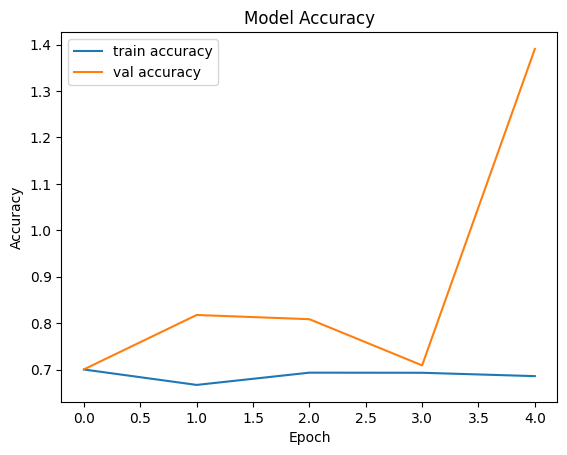

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train accuracy', 'val accuracy'])
plt.show()

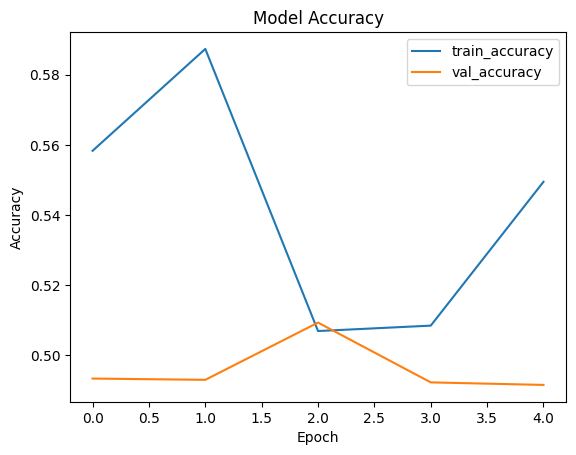

In [74]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# Model Evaluation and testing

In [75]:
test_dataset = test_dataset.batch(1)

In [76]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 38s 8ms/step - loss: 1.3461 - accuracy: 0.5053 - tp: 1.0000 - tn: 1392.0000 - fn: 1359.0000 - fp: 5.0000 - precision: 0.1667 - recall: 7.3529e-04


[1.3460636138916016,
 0.5052593350410461,
 1.0,
 1392.0,
 1359.0,
 5.0,
 0.1666666716337204,
 0.000735294132027775]

In [77]:
def parasite_or_not(x):
  if (x < 0.5):
    return str('P')
  else:
    return str('U')

In [78]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 [==============================] - 17s 17s/step


'P'

1/1 [==============================] - 0s 29ms/step


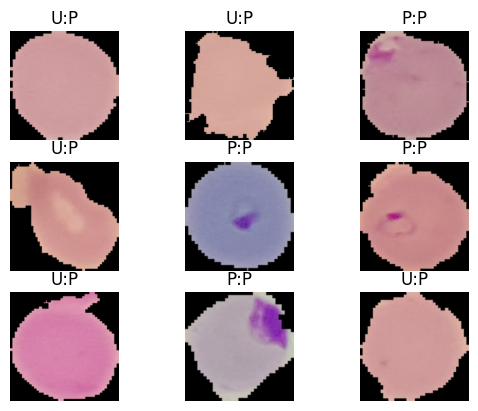

In [79]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')